# 基本Verilog矽智產電路(IP)包裝整合燒錄驗證流程

# 一、設計電路

# 二、使用Vivado HLx (IPI)包裝成IP

    (a) 開啟Vivado 2018.2
    
    (b) Create Project > Next > Project name: *, Project location: ..\* > Next
    
    (c) 勾選 RTL Project > Next
    
    (d) Target language: Verilog, Simulator language: Verilog > Next > Next

    (e) Board: pynq-z2 > Next > Finish

    (f) Tools > Create and Package New IP > Next > 勾選 Create a New AXI4 Peripheral > Next
    
    (g) Name: * > Next > Next > 勾選 Edit IP > Finish

    (h) 在Sources面板Hierarchy頁面Design Sources雙擊點選IP包裝檔*_V1_0_S00_AXI.v
    
    (i) 在第三行加入：「`include "存放*.v的位置路徑"」，在內部適當宣告與連線，存檔。(*_V1_0_S00_AXI.v更改處如下圖)

    (j) 在Package IP版面選Review and Package頁面 > Re-Package > Yes。

    (k) IP INTEGRATOR(IPI) > Create Block Design > Design name: * > OK
    
    (l) Add IP (+) ZYNQ7 Processing System > Add IP (+) *
    
    (m) Run Block Automation > OK > Run Connection Automation > 勾選 All Automation > OK > Regenerate Layout > Save Block Design 
    
    (n) Address Editor查看ip被分配位址 > Sources的Hierarchy右鍵Block Design(*.bd)產生頂層包裝Create HDL wrapper > OK 
    
    (o) 在Program and Debug點選Generate Bitstream > Yes > OK > 等待一段時間等他跑完 > 查看implementation或report或Cancel > OK

    (p) File > Export Hardware > OK
    
    (q) File > Export Bitstream > *.bit > Save 
    
    (r) 在底下TCL Console拷貝剛才的路徑，再輸入： write_bd_tcl 路徑/*.tcl
    
    (s) 以檔案總管貼上剛剛的路徑，將project資料匣\srcs資料匣...\hw_handoff\ *.hwh拷貝至此，並將.bit, .tcl, .hwh三檔命名相同檔名
    
    (t) 關閉Vivado

In [2]:
###定義IEEE754浮點數格式字串跟實際浮點數的互相轉換之函式
from codecs import decode
import struct

def float_to_binary(input: float) -> str:
    return ''.join(format(c, '08b') for c in struct.pack('!f', input))

def bin_to_float(b):
    """ Convert binary string to a float. """
    bf = int_to_bytes(int(b, 2), 4)  # 8 bytes needed for IEEE 754 binary64.
    return struct.unpack('>f', bf)[0]


def int_to_bytes(n, length):  # Helper function
    """ Int/long to byte string.

        Python 3.2+ has a built-in int.to_bytes() method that could be used
        instead, but the following works in earlier versions including 2.x.
    """
    return decode('%%0%dx' % (length << 1) % n, 'hex')[-length:]


def float_to_bin(value):  # For testing.
    """ Convert float to 64-bit binary string. """
    [d] = struct.unpack(">L", struct.pack(">f", value))
    return '{:032b}'.format(d)

#測試函式有無錯誤
if __name__ == '__main__':
    for f in 0.0, 1.0, -14.0, 12.546, 3.141593:
        print('Test value: %f' % f)
        binary = float_to_bin(f)
        print(f' float_to_bin: {binary}, {type(binary)}')
        floating_point = bin_to_float(binary)  # Round trip.
        print(f' bin_to_float: {floating_point}, {type(floating_point)}\n')

Test value: 0.000000
 float_to_bin: 00000000000000000000000000000000, <class 'str'>
 bin_to_float: 0.0, <class 'float'>

Test value: 1.000000
 float_to_bin: 00111111100000000000000000000000, <class 'str'>
 bin_to_float: 1.0, <class 'float'>

Test value: -14.000000
 float_to_bin: 11000001011000000000000000000000, <class 'str'>
 bin_to_float: -14.0, <class 'float'>

Test value: 12.546000
 float_to_bin: 01000001010010001011110001101010, <class 'str'>
 bin_to_float: 12.545999526977539, <class 'float'>

Test value: 3.141593
 float_to_bin: 01000000010010010000111111011100, <class 'str'>
 bin_to_float: 3.1415929794311523, <class 'float'>



In [3]:
###定義將Posit32格式字串轉為Posit32數值之函式
def posit_str_to_f(posit, es):
    if '1' not in posit:
        return 0
    else:
        sign = posit[0]
        x = 1
        if sign == '1':
            p = '1'
            for i in range(len(posit)):
                if i>0:
                    if posit[i] == '0':
                        p += '1'
                    elif posit[i] == '1':
                        p += '0'
            posit = p
        if posit[1] == '0':
            for b in posit[1:]:
                if b == '1':
                    regime = posit[1:x+1]
                    break
                else:
                    regime = posit[1:x+1]
                x += 1
        elif posit[1] == '1':
            for b in posit[1:]:
                if b == '0':
                    regime = posit[1:x+1]
                    break
                else:
                    regime = posit[1:x+1]
                x += 1

        exponent = posit[x+1:x+1+es]
        mantissa = posit[x+1+es:]
        #print(f'{sign}, {regime}, {exponent}, {mantissa}')
        #因為Posit number = sf2^(k2^p+e)，所以要找出s, f, k, p, e的值
        #s
        s = (-1)**int(sign)

        #f
        f = 1
        for i in range(len(mantissa)):
            f += int(mantissa[i])*(2**(-(i+1)))
        if sign == '1':
            f += 2**((-1)*len(mantissa))
        #k
        if regime[0] == '1':
            k = -1
            for r in regime:
                if r == '1':
                    k += 1
        elif regime[0] == '0':
            k = 0
            for r in regime:
                if r == '0':
                    k -= 1
        #p    
        p = es
        #e
        e = 0
        for i in range(len(exponent)):
            if exponent[-i-1] == '1':
                e += 2**(i)
        posit_f = s*f*(2**(k*(2**p)+e))
        #print(f'{sign}, {regime}, {exponent}, {mantissa}')
        #print(f'{s}, {f}, {k}, {p}, {e}')
        return posit_f

# 三、將包裝完的IP傳至Pynq-z2加以例證

## Posit32

In [30]:
#Posit32
import time
from pynq import Overlay
from pynq import MMIO
op_list = ["add", "sub", "mul"]
for op in op_list:
    #print("====================================================================================================================")
    ol = Overlay(f'./bitstream/posit_{op}32.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    str_in1 = []
    str_in2 = []
    str_out = []
    A_posit32_path = "./random_float_numbers/random_posit32_A.txt"
    B_posit32_path = "./random_float_numbers/random_posit32_B.txt"
    O_posit32_path = f"./random_float_numbers/random_posit32_AB_{op}.txt"
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
            
    count = 0
    Pass = 1
    posit_operation_time = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)

        ####################
        start = time.time()
        myip.write(0, in1)
        myip.write(4, in2)  #一個暫存器4-byte，也就是32-bit。
        result = myip.read(8)
        end = time.time()
        posit_operation_time += end - start
        ####################

        #print(myip.read(0), myip.read(4), myip.read(8))
        a = '{:032b}'.format(myip.read(0))
        b = '{:032b}'.format(myip.read(4))
        str_result = '{:032b}'.format(result)
        #print("in1 + in2 = out = golden_pattern")
        #print(f'{posit_str_to_f(a, 2)} + {posit_str_to_f(b, 2)} = {posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out[i], 2)}')
        #print(bin(myip.read(0)))
        #print(f'{str_in1[i]} + {str_in2[i]} = ')
        #print(f'{str_result} = {str_out[i]}')
        #print()
        if (posit_str_to_f(str_result, 2) != posit_str_to_f(str_out[i], 2)):
            count += 1
            Pass = 0
        if (i==7):
            print(f"in1 {op} in2 = HW_result = Golden Pattern")
            print(f'{str_in1[i]} {op} {str_in2[i]} = ')
            print(f'{str_result}  =  {str_out[i]}')
            print(f'{posit_str_to_f(str_in1[i], 2)} {op} {posit_str_to_f(str_in2[i], 2)} = ', end = ' ')
            print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out[i], 2)}')
            print()
    """
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print(f"posit_{op}_operation_time: {posit_operation_time}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")
    """

in1 add in2 = HW_result = Golden Pattern
01111100100001010000111101111000 add 01111101011000011110010011100101 = 
01111101100100100011011001010000  =  01111101100100100011011001010000
136253.875 add 462631.15625 =  598885.0 = 598885.0

in1 sub in2 = HW_result = Golden Pattern
01111100100001010000111101111000 sub 01111101011000011110010011100101 = 
10000010111000001010001011010111  =  10000010111000001010001011010111
136253.875 sub 462631.15625 =  -326377.28125 = -326377.28125

in1 mul in2 = HW_result = Golden Pattern
01111100100001010000111101111000 mul 01111101011000011110010011100101 = 
01111111110111101010110100110010  =  01111111110111101010110100110010
136253.875 mul 462631.15625 =  63035277312.0 = 63035277312.0



## Float_add32

In [17]:
#Float_add32
from pynq import Overlay
from pynq import MMIO

ol = Overlay('./bitstream/Float_add32.bit')
myip = MMIO(0x43C00000, 0x10000)

In [18]:
str_in1 = "01000000010010010000111111011011" #3.1415927410125732
str_in2 = "01000001101001000000000000000000" #20.5
in1 = int("0b"+str_in1, 2)
in2 = int("0b"+str_in2, 2)
myip.write(0, in1)
myip.write(4, in2)  #一個暫存器4-byte，也就是32-bit。
#print(myip.read(0), myip.read(4), myip.read(8), myip.read(16))

a = '{:032b}'.format(myip.read(0))
b = '{:032b}'.format(myip.read(4))
r = '{:032b}'.format(myip.read(8))
exception = '{:032b}'.format(myip.read(16))
print(a, b)
print(r, exception)
print(f'{bin_to_float(a)} + {bin_to_float(b)} = {bin_to_float(r)}, exception = {bin_to_float(exception)}')

01000000010010010000111111011011 01000001101001000000000000000000
01000001101111010010000111111011 01000000010010010000111111011011
3.1415927410125732 + 20.5 = 23.641592025756836, exception = 3.1415927410125732


## Float32

In [29]:
#Float32
import time
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    #print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Float_{op}32.bit')
    myip = MMIO(0x43C00000, 0x10000)

    A_float32_path = "./random_float_numbers/random_float32_A.txt"
    B_float32_path = "./random_float_numbers/random_float32_B.txt"
    O_float32_path = f"./random_float_numbers/random_float32_AB_{op}.txt"
    str_in1 = []
    str_in2 = []
    str_out = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])

    Pass = 1
    count = 0
    Float_total_time = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        
        ####################
        start = time.time()
        myip.write(0, in1)
        myip.write(4, in2)  #一個暫存器4-byte，也就是32-bit。
        result = myip.read(8)
        end = time.time()
        Float_total_time += end - start
        ####################

        #print(myip.read(0), myip.read(4), myip.read(8))
        
        
        a = '{:032b}'.format(myip.read(0))
        b = '{:032b}'.format(myip.read(4))
        str_result = '{:032b}'.format(result)

        if (bin_to_float(str_result) != bin_to_float(str_out[i])): #硬體與golden pattern做比較
            Pass = 0
            count += 1
        if(i==7):
            print(f"in1 {op} in2 = HW_result = Golden Pattern")
            print(f"{a} {op} {b} =")
            print(f"{str_result}  =  {str_out[i]}")
            print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out[i])}')
            print()
    """
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print(f"float_{op}_operation_time = {Float_total_time}s")
    print("====================================================================================================================")
    print("\n\n\n\n\n")
    """

in1 add in2 = HW_result = Golden Pattern
01001000000001010000111101111000 add 01001000111000011110010011100101 =
01001001000100100011011001010000  =  01001001000100100011011001010000
136253.875 add 462631.15625 = 598885.0 = 598885.0

in1 sub in2 = HW_result = Golden Pattern
01001000000001010000111101111000 sub 01001000111000011110010011100101 =
11001000100111110101110100101001  =  11001000100111110101110100101001
136253.875 sub 462631.15625 = -326377.28125 = -326377.28125

in1 mul in2 = HW_result = Golden Pattern
01001000000001010000111101111000 mul 01001000111000011110010011100101 =
01010001011010101101001100100011  =  01010001011010101101001100100011
136253.875 mul 462631.15625 = 63035289600.0 = 63035289600.0



## Flosit32: Float32 part

In [37]:
#Flosit32: Float32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    #print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = "./random_float_numbers/random_float32_A.txt"
    B_float32_path = "./random_float_numbers/random_float32_B.txt"
    O_float32_path = f"./random_float_numbers/random_float32_AB_{op}.txt"
    str_in1 = []
    str_in2 = []
    str_out = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])

    Pass = 1
    count = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b111) #輸入Float, 要輸出Float, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
            
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)

        if (bin_to_float(str_result) != bin_to_float(str_out[i])): #硬體與golden pattern做比較
            Pass = 0
            count += 1
        if(i==7):
            print(f"in1 {op} in2 = HW_result = Golden Pattern")
            print(f"{a} {op} {b} = ")
            print(f"{str_result}  =  {str_out[i]}")
            print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out[i])}')
            print()
    """
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")
    """

in1 add in2 = HW_result = Golden Pattern
01001000000001010000111101111000 add 01001000111000011110010011100101 = 
01001001000100100011011001010000  =  01001001000100100011011001010000
136253.875 add 462631.15625 = 598885.0 = 598885.0

in1 sub in2 = HW_result = Golden Pattern
01001000000001010000111101111000 sub 01001000111000011110010011100101 = 
11001000100111110101110100101001  =  11001000100111110101110100101001
136253.875 sub 462631.15625 = -326377.28125 = -326377.28125

in1 mul in2 = HW_result = Golden Pattern
01001000000001010000111101111000 mul 01001000111000011110010011100101 = 
01010001011010101101001100100011  =  01010001011010101101001100100011
136253.875 mul 462631.15625 = 63035289600.0 = 63035289600.0



## Flosit32: Posit32 part

In [34]:
#Flosit32: Posit32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    #print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)

    str_in1 = []
    str_in2 = []
    str_out = []
    A_posit32_path = "./random_float_numbers/random_posit32_A.txt"
    B_posit32_path = "./random_float_numbers/random_posit32_B.txt"
    O_posit32_path = f"./random_float_numbers/random_posit32_AB_{op}.txt"
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
        
    count = 0
    Pass = 1
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b000) #輸入Posit, 要輸出Posit, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
        #print(myip.read(0), myip.read(4), myip.read(8))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)
        #print("in1 + in2 = out = golden_pattern")
        #print(f'{posit_str_to_f(a, 2)} + {posit_str_to_f(b, 2)} = {posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out[i], 2)}')
        #print(bin(myip.read(0)))
        #print(f'{str_in1[i]} + {str_in2[i]} = ')
        #print(f'{str_result} = {str_out[i]}')
        #print()
        if (posit_str_to_f(str_result, 2) != posit_str_to_f(str_out[i], 2)):
            Pass = 0
            count += 1
        if(i==7):
            print(f"in1 {op} in2 = HW_result = Golden Pattern")
            print(f'{str_in1[i]} {op} {str_in2[i]} = ')
            print(f'{str_result}  =  {str_out[i]}')
            print(f'{posit_str_to_f(str_in1[i], 2)} {op} {posit_str_to_f(str_in2[i], 2)} = ', end = ' ')
            print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out[i], 2)}')
            print()
    """
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")
    """

in1 add in2 = HW_result = Golden Pattern
01111100100001010000111101111000 add 01111101011000011110010011100101 = 
01111101100100100011011001010000  =  01111101100100100011011001010000
136253.875 add 462631.15625 =  598885.0 = 598885.0

in1 sub in2 = HW_result = Golden Pattern
01111100100001010000111101111000 sub 01111101011000011110010011100101 = 
10000010111000001010001011010111  =  10000010111000001010001011010111
136253.875 sub 462631.15625 =  -326377.28125 = -326377.28125

in1 mul in2 = HW_result = Golden Pattern
01111100100001010000111101111000 mul 01111101011000011110010011100101 = 
01111111110111101010110100110010  =  01111111110111101010110100110010
136253.875 mul 462631.15625 =  63035277312.0 = 63035277312.0



## Flosit32: Flosit32 part(2 Float input, but Posit output)

In [35]:
#Flosit32: Posit32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    #print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = "./random_float_numbers/random_float32_A.txt"
    B_float32_path = "./random_float_numbers/random_float32_B.txt"
    O_P_posit32_path = f"./random_float_numbers/random_posit32_AB_{op}.txt"
    O_F_float32_path = f"./random_float_numbers/random_float32_AB_{op}.txt"
    str_in1 = []
    str_in2 = []
    str_out_F = []
    str_out_P = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_F_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_F.append(str_num_out[0:-1])
    with open(O_P_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_P.append(str_num_out[0:-1])

    Pass = 1
    count = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b011) #輸入Float, 但是要輸出Posit, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
            
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)

        if (bin_to_float(str_result) != bin_to_float(str_out_F[i])) and (posit_str_to_f(str_result, 2) != posit_str_to_f(str_out_P[i], 2)): #硬體與golden pattern做比較
            Pass = 0
            count += 1
        if(i==7):
            print(f"in1 {op} in2 = HW_result = Golden Pattern")
            if(myip.read(0)&0b100):
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_F[i]}')
                if(myip.read(0)==0b100):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b101):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b110):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b111):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
            else:
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_P[i]}')
                if(myip.read(0)==0b000):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b001):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b010):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b011):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
    """
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")
    """

in1 add in2 = HW_result = Golden Pattern
01001000000001010000111101111000 add 01001000111000011110010011100101 = 
01111101100100100011011001010000  =  01111101100100100011011001010000
136253.875 add 462631.15625 =  598885.0 = 598885.0

in1 sub in2 = HW_result = Golden Pattern
01001000000001010000111101111000 sub 01001000111000011110010011100101 = 
10000010111000001010001011010111  =  10000010111000001010001011010111
136253.875 sub 462631.15625 =  -326377.28125 = -326377.28125

in1 mul in2 = HW_result = Golden Pattern
01001000000001010000111101111000 mul 01001000111000011110010011100101 = 
01111111110111101010110100110010  =  01111111110111101010110100110010
136253.875 mul 462631.15625 =  63035277312.0 = 63035277312.0



## Flosit32: Flosit32 part(2 Posit input, but Float output)

In [36]:
#Flosit32: Flosit32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    #print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = "./random_float_numbers/random_posit32_A.txt"
    B_float32_path = "./random_float_numbers/random_posit32_B.txt"
    O_P_posit32_path = f"./random_float_numbers/random_posit32_AB_{op}.txt"
    O_F_float32_path = f"./random_float_numbers/random_float32_AB_{op}.txt"
    str_in1 = []
    str_in2 = []
    str_out_F = []
    str_out_P = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_F_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_F.append(str_num_out[0:-1])
    with open(O_P_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_P.append(str_num_out[0:-1])

    Pass = 1
    count = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b100) #輸入Posit, 但是要輸出Float, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
            
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)

        if (bin_to_float(str_result) != bin_to_float(str_out_F[i])) and (posit_str_to_f(str_result, 2) != posit_str_to_f(str_out_P[i], 2)): #硬體與golden pattern做比較
            Pass = 0
            count += 1
        if (i==7):
            print(f"in1 {op} in2 = HW_result = Golden Pattern")
            if(myip.read(0)&0b100):
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_F[i]}')
                if(myip.read(0)==0b100):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b101):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b110):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b111):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
            else:
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_P[i]}')
                if(myip.read(0)==0b000):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b001):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b010):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b011):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
    """
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")
    """

in1 add in2 = HW_result = Golden Pattern
01111100100001010000111101111000 add 01111101011000011110010011100101 = 
01001001000100100011011001010000  =  01001001000100100011011001010000
136253.875 add 462631.15625 = 598885.0 = 598885.0

in1 sub in2 = HW_result = Golden Pattern
01111100100001010000111101111000 sub 01111101011000011110010011100101 = 
11001000100111110101110100101001  =  11001000100111110101110100101001
136253.875 sub 462631.15625 = -326377.28125 = -326377.28125

in1 mul in2 = HW_result = Golden Pattern
01111100100001010000111101111000 mul 01111101011000011110010011100101 = 
01010001011010101101001100100011  =  01010001011010101101001100100011
136253.875 mul 462631.15625 = 63035289600.0 = 63035289600.0



## Flosit32: Flosit32 part(1 Posit & 1 Float input, but Float output)

In [16]:
#Flosit32: Flosit32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = "./random_float_numbers/random_float32_A.txt"
    B_float32_path = "./random_float_numbers/random_posit32_B.txt"
    O_P_posit32_path = f"./random_float_numbers/random_posit32_AB_{op}.txt"
    O_F_float32_path = f"./random_float_numbers/random_float32_AB_{op}.txt"
    str_in1 = []
    str_in2 = []
    str_out_F = []
    str_out_P = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_F_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_F.append(str_num_out[0:-1])
    with open(O_P_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_P.append(str_num_out[0:-1])

    Pass = 1
    count = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b101) #輸入Float與Posit, 但是要輸出Float, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
            
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)

        if (bin_to_float(str_result) != bin_to_float(str_out_F[i])) and (posit_str_to_f(str_result, 2) != posit_str_to_f(str_out_P[i], 2)): #硬體與golden pattern做比較
            Pass = 0
            count += 1
            if(myip.read(0)&0b100):
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_F[i]}')
                if(myip.read(0)==0b100):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b101):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b110):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b111):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
            else:
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_P[i]}')
                if(myip.read(0)==0b000):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b001):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b010):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b011):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")

01000001010010101011101011111001 add 01110011101111110111110100111101 = 
01000100011100110000101000111010  =  01000100011100110000101000111011
12.670647621154785 add 959.4892120361328 = 972.1597900390625 = 972.1598510742188

01000000110101111101001010101000 add 10000011110011100000101110100011 = 
11000111101100011111000011111101  =  11000111101100011111000011111110
6.744464874267578 add -91112.7265625 = -91105.9765625 = -91105.984375

11001001010000010101110101111010 add 01011101100100100101011111101010 = 
11001001010000010101110010100000  =  11001001010000010101110010100001
-792023.625 add 13.571653962135315 = -792010.0 = -792010.0625

01000001110100100100010010100110 add 10111110001000011110100011001101 = 
01000001110010000110011010001110  =  01000001110010000110011010001111
26.283519744873047 add -1.2334426864981651 = 25.05007553100586 = 25.050077438354492

11000000110001011100101000011111 add 10000000000001011010100110000011 = 
11010110101010110011111010000000  =  11010110101010110

-1.0293941497802734 add 708239872.0 = 708239808.0 = 708239872.0

11001110111010111010011011100011 add 10000000100000001000101001110011 = 
11001111000001011011000011010100  =  11001111000001011011000011010101
-1976791424.0 add -266167104.0 = -2242958336.0 = -2242958592.0

01000011110111110000001011101000 add 01010000010110100111111000001011 = 
01000011111000010001100110000111  =  01000011111000010001100110001000
446.022705078125 add 4.176742881536484 = 450.1994323730469 = 450.199462890625

10111111101011111100110001011010 add 01011111110100110011001011001011 = 
01000001011001110011100110100000  =  01000001011001110011100110100010
-1.3734238147735596 add 15.824993789196014 = 14.451568603515625 = 14.451570510864258

01000000001001110101010001000001 add 01000000110110010010011000011100 = 
01000000011011100001110101110001  =  01000000011011100001110101110010
2.6145174503326416 add 1.1060297191143036 = 3.7205469608306885 = 3.7205471992492676

11000000010000010001010010010110 add 011111111100

1.8110487461090088 add -75652960.0 = -75652952.0 = -75652968.0

11000001000011110100110011110100 add 01100101001000110001000100101110 = 
01000010000000001000111011101000  =  01000010000000001000111011101001
-8.956287384033203 add 41.09584712982178 = 32.139556884765625 = 32.13956069946289

01000001100011110100000001001001 add 10000101001011111000001010101010 = 
11000110111010000001101011011010  =  11000110111010000001101011011011
17.906389236450195 add -29727.333984375 = -29709.42578125 = -29709.427734375

11000011001110001000100110011110 add 01111110110010000000110000010001 = 
01001011000100000001011101101001  =  01001011000100000001011101101010
-184.53756713867188 add 9443362.0 = 9443177.0 = 9443178.0

11000011110010010011001110100010 add 10000101011110100110111001100100 = 
11000110110001011110110110011100  =  11000110110001011110110110011101
-402.40338134765625 add -24932.40234375 = -25334.8046875 = -25334.806640625

00111111011010000001110000101100 add 101101100000111001100000000101

11000010100000100001111111100100 add 01010001001011001110011001000000 = 
11000010011100011110010111111010  =  11000010011100011110010111111100
-65.06228637695312 add 4.58769416809082 = -60.474586486816406 = -60.47459411621094

11001101101001100100011010101110 add 10000000011101101000000111110111 = 
11001110001110010001101101111011  =  11001110001110010001101101111100
-348706240.0 add -427690240.0 = -776396480.0 = -776396544.0

01000000001010100100010100110111 add 01111000000011111001100001011110 = 
01000101100001111110000101110111  =  01000101100001111110000101111000
2.6604745388031006 add 4345.52294921875 = 4348.18310546875 = 4348.18359375

01000000100011000011010011010110 add 10011010010110110010100110100010 = 
11000010001000110001010000110000  =  11000010001000110001010000110001
4.3814496994018555 add -45.15116786956787 = -40.76971435546875 = -40.769718170166016

01000001111000001111000011011000 add 01111111001001101010010100010000 = 
01001100000110101001010001000111  =  01001100000

11000010001000000100000110101111  =  11000010001000000100000110110000
21.866941452026367 add -61.93108797073364 = -40.064144134521484 = -40.06414794921875

01000010101101000001110000000010 add 10000000000101111011000000110001 = 
11010010100010011111100111100000  =  11010010100010011111100111100010
90.05470275878906 add -296301363200.0 = -296301363200.0 = -296301428736.0

11000000111010000001010001010100 add 01111111101111100101101100011010 = 
01001111011100101101100011001111  =  01001111011100101101100011010011
-7.252481460571289 add 4074295296.0 = 4074295040.0 = 4074296064.0

11000011011001010110110010100010 add 10000000000000000010110000111011 = 
11100000101111000101000000000000  =  11100000101111000101010110000010
-229.42434692382812 add -1.0855476541813844e+20 = -1.0855476541813844e+20 = -1.0856716790929975e+20

11000011000001110001001110110100 add 10111110101011111011001000011000 = 
11000011000010000011110110111101  =  11000011000010000011110110111110
-135.07696533203125 add -1.16

10111111101010110010111100101111 add 10001001000000100100001011001000 = 
11000101001111111000010010110011  =  11000101001111111000010010110100
-1.3373774290084839 add -3062.95654296875 = -3064.293701171875 = -3064.2939453125

11000000010000111100100010101101 add 10000001101010100100110010000101 = 
11001010001010110110011100000010  =  11001010001010110110011100000001
-3.0591232776641846 add -2808253.5 = -2808256.5 = -2808256.25

01000001100001111000110101100110 add 01111111101110001110001001110100 = 
01001111010001110001001110100000  =  01001111010001110001001110100011
16.944042205810547 add 3339952128.0 = 3339952128.0 = 3339952896.0

10111111100101100010110001000011 add 01100101100010101111101011000111 = 
01000010001011001010110111110101  =  01000010001011001010110111110111
-1.1732257604599 add 44.34311246871948 = 43.16987991333008 = 43.16988754272461

01000000111110110111100011111010 add 10001101110011110011111101010110 = 
11000100000010100011100100111000  =  1100010000001010001110010

01001001100011001111100101011000 add 10000000010000101100111000011010 = 
11001111011010010111110110010000  =  11001111011010010111110110001111
1154859.0 add -3918475264.0 = -3917320192.0 = -3917319936.0

01011000000111101011111011011000 add 10000001010101100011010011111111 = 
01011000000111101011111011010111  =  01011000000111101011111011011000
698170019414016.0 add -6933249.0 = 698169952305152.0 = 698170019414016.0

01000100001110010000111011110100 add 01111110001000001111100001011111 = 
01001001110000100000011111011111  =  01001001110000100000011111100000
740.233642578125 add 1588759.75 = 1589499.875 = 1589500.0

11000000001000101011011100101010 add 01110001011100110100001001110000 = 
01000011110110111000101100101101  =  01000011110110111000101100101110
-2.5424294471740723 add 441.6297607421875 = 439.0873107910156 = 439.08734130859375

01000001011111111010011100011010 add 10000001001110110101011000011110 = 
11001011000010010101001110110100  =  11001011000010010101001110110011
15.9782

10111111110011000100111110010011 add 10000000100111011011001000110000 = 
11001101000010010011011101000000  =  11001101000010010011011100111110
-1.596178412437439 add -143881216.0 = -143881216.0 = -143881184.0

00111111010011100110100101011000 add 10001111111000111111010010111001 = 
11000011100001101001101110011100  =  11000011100001101001101110011101
0.8062949180603027 add -270.0220260620117 = -269.2156982421875 = -269.2157287597656

11000001111110011011111000011001 add 01101001010000011101011001000111 = 
01000010010100111001011010000010  =  01000010010100111001011010000110
-31.21782112121582 add 84.11481380462646 = 52.89698028564453 = 52.896995544433594

01001101010111110110001111101001 add 10110101110010011010000000001010 = 
01001101010111110110001111101000  =  01001101010111110110001111101001
234241680.0 add -2.553100436925888 = 234241664.0 = 234241680.0

11001111110001000101011110011010 add 10000010000111011000100000000110 = 
11001111110001000101111010101101  =  1100111111000100010

01000100010111001000011100011001  =  01000100010111001000011100011010
-17.494596481323242 add 899.6055297851562 = 882.1109008789062 = 882.1109619140625

11000000001100100011001010111010 add 10100110011010011001000000100011 = 
11000001010001011111001110101011  =  11000001010001011111001110101100
-2.784346103668213 add -9.587644398212433 = -12.371989250183105 = -12.371990203857422

11001010010101111000001101010100 add 10100111110010111001010111000100 = 
11001010010101111000001101110100  =  11001010010101111000001101110101
-3530965.0 add -8.204746007919312 = -3530973.0 = -3530973.25

01000001011101010111101101011100 add 00111000000010000010110111001000 = 
01000001011111011000001110001001  =  01000001011111011000001110001010
15.34261703491211 add 0.501996785402298 = 15.844613075256348 = 15.844614028930664

01001101001011101000110101000111 add 10111100110010110100001001111010 = 
01001101001011101000110101000110  =  01001101001011101000110101000111
183030896.0 add -1.4007521122694016 = 18303

01000000101000000100000101011110 sub 01111101001000100101100110010010 = 
11001000101000100101100011110001  =  11001000101000100101100011110010
5.007979393005371 sub 332492.5625 = -332487.53125 = -332487.5625

11000000110001011100101000011111 sub 10000000000001011010100110000011 = 
01010110101010110011111010000000  =  01010110101010110011111010001011
-6.180922985076904 sub -94142461902848.0 = 94142461902848.0 = 94142554177536.0

01000011000110010011111010010101 sub 01111111000000010110111111111110 = 
11001011100001011011111110101011  =  11001011100001011011111110101010
153.2444610595703 sub 17530864.0 = -17530710.0 = -17530708.0

01001000111010100011100000000111 sub 01110010010011100010100010010111 = 
01001000111010011110111001000001  =  01001000111010011110111001000010
479680.21875 sub 590.1585540771484 = 479090.03125 = 479090.0625

11000000100100011111011001110001 sub 10000001101010111111110010100000 = 
01001010001010000000011010101101  =  01001010001010000000011010101110
-4.561333179

628.4826049804688 sub -8.450620293617249 = 636.9331665039062 = 636.9332275390625

10111111101011111100110001011010 sub 01011111110100110011001011001011 = 
11000001100010011001011001011011  =  11000001100010011001011001011100
-1.3734238147735596 sub 15.824993789196014 = -17.198415756225586 = -17.19841766357422

11000000010000010001010010010110 sub 01111111110010000010110010010101 = 
11010000000000101100100101010000  =  11010000000000101100100101010111
-3.0168814659118652 sub 8776925184.0 = -8776925184.0 = -8776932352.0

11000000000001001010011101011101 sub 10000000111011001110111011010010 = 
01001011110011000100010010110110  =  01001011110011000100010010111000
-2.0727150440216064 sub -26773872.0 = 26773868.0 = 26773872.0

00111111010101000001100101000011 sub 10110110110011011000101110110111 = 
01000000010010000010110110010100  =  01000000010010000010110110010110
0.8285104632377625 sub -2.2992717176675797 = 3.127781867980957 = 3.1277823448181152

01000001010101001110000111001111 sub 0111

01010001000001000010011111000011 sub 10000000000100001001110001101101 = 
01010011011101001011010011011100  =  01010011011101001011010011011101
35475173376.0 sub -1015531175936.0 = 1051006337024.0 = 1051006402560.0

10111111101111011110011101111011 sub 10110110000010001010101100100010 = 
00111111100000010000001100011110  =  00111111100000010000001100100001
-1.4836267232894897 sub -2.4915346801280975 = 1.0079076290130615 = 1.0079079866409302

01001011101101010000001111000100 sub 10000000110101111110111010100100 = 
01001100011110101100011101010010  =  01001100011110101100011101010011
23725960.0 sub -42014144.0 = 65740104.0 = 65740108.0

11000010011011000011001001010100 sub 10101001001110101011001111101000 = 
11000010010011101010011110111011  =  11000010010011101010011110111100
-59.04914855957031 sub -7.385346174240112 = -51.66379928588867 = -51.66380310058594

10111111110011000101011010110110 sub 10011011111000101100000111100011 = 
01000001111110101000101000011010  =  01000001111110101000

882735.0625 sub -1.1775556057691574 = 882736.1875 = 882736.25

01001000001000110001001111111111 sub 10000000110110101111010011001011 = 
01001100000101001100111111100111  =  01001100000101001100111111101000
166991.984375 sub -38843216.0 = 39010204.0 = 39010208.0

01000010111101101101111101001111 sub 10111111110010110110110101111110 = 
01000010111110001110110001110011  =  01000010111110001110110001110100
123.43614959716797 sub -1.0256700664758682 = 124.4618148803711 = 124.46182250976562

11000011100000100101101110111111 sub 10000000001001010010011101001010 = 
01010001001011011000101101011111  =  01010001001011011000101101011110
-260.7167663574219 sub -46585479168.0 = 46585475072.0 = 46585470976.0

11000000010111101110111110100000 sub 01111110010110011011001000011101 = 
11001010001100110110010001000111  =  11001010001100110110010001001000
-3.4833755493164062 sub 2939150.5 = -2939153.75 = -2939154.0

11010000000110111011010111100111 sub 10100111010011011001110110011011 = 
11010000000110111

01000000100000000100110010000110 sub 01111101100001101011101010100100 = 
11001001000001101011101001100011  =  11001001000001101011101001100100
4.009341239929199 sub 551850.25 = -551846.1875 = -551846.25

01010001100100110101011100001110 sub 10000001101011110001001100101101 = 
01010001100100110101100001010001  =  01010001100100110101100001010010
79102590976.0 sub -2651753.5 = 79105236992.0 = 79105245184.0

11001100100101100010011101011010 sub 01111101111001010111110011011110 = 
11001100100101111111001001010011  =  11001100100101111111001001010100
-78723792.0 sub 939981.875 = -79663768.0 = -79663776.0

00111111111000001001010110111010 sub 01010011010101000111000110000011 = 
11000000011110100100001101010010  =  11000000011110100100001101010011
1.7545692920684814 sub 5.664928525686264 = -3.9103589057922363 = -3.9103591442108154

11001111000010011111101110111110 sub 01111010010101111111001000001100 = 
11001111000010011111110000010011  =  11001111000010011111110000010100
-2314976768.0 sub 22

01000100011101100010011101001010 sub 01110110010110010100000100011011 = 
11000100101100011000110011100110  =  11000100101100011000110011101001
984.6138916015625 sub 2405.0172729492188 = -1420.403076171875 = -1420.4034423828125

11000000011010001101000110010110 sub 01111111111111100000001111000111 = 
11011001100001111000111000000000  =  11011001100001111000110100010101
-3.6377921104431152 sub 4769406563385344.0 = -4769406563385344.0 = -4769280398721024.0

00111111111000010000110100001001 sub 10111100011101011011101101100000 = 
01000000010011001101100010101001  =  01000000010011001101100010101010
1.758210301399231 sub -1.4425137042999268 = 3.200723886489868 = 3.2007241249084473

01000011010010110000100100001110 sub 01111110110100000001101101010000 = 
11001011001000000011010111010100  =  11001011001000000011010111010101
203.03536987304688 sub 10499744.0 = -10499540.0 = -10499541.0

01000001100001111000110101100110 sub 01111111101110001110001001110100 = 
11001111010001110001001110011111  =

01000000000000001010001110000111 sub 01111110110011111001000011110011 = 
11001011000111110010000111100011  =  11001011000111110010000111100100
2.0099809169769287 sub 10428902.0 = -10428899.0 = -10428900.0

11000000010010110001110010100111 sub 10101101001011111100111000000110 = 
01000000000011101110100110010110  =  01000000000011101110100110011001
-3.17362380027771 sub -5.406631290912628 = 2.2330069541931152 = 2.2330076694488525

10111111101000110001111001111010 sub 01111111110111010100001111110011 = 
11010001010101000011111100110000  =  11010001010101000011111100110010
-1.2743675708770752 sub 56974573568.0 = -56974573568.0 = -56974581760.0

01001011100101011111100000101110 sub 01110111000011010011001010010000 = 
01001011100101011111001000010011  =  01001011100101011111001000010100
19656796.0 sub 3124.7900390625 = 19653670.0 = 19653672.0

00111111001110111100110100100010 sub 01111111100010000100010101100011 = 
11001101110000100010101100010111  =  11001101110000100010101100010100
0.73359

11001000101101101011101100000011 sub 01111010111011101100001011010011 = 
11001000110001100011000100011001  =  11001000110001100011000100011010
-374232.09375 sub 31664.7060546875 = -405896.78125 = -405896.8125

00111111110000111000110001111000 sub 10000000000000111111101110011000 = 
01010111100001000110100000000000  =  01010111100001000110100000011000
1.527724266052246 sub -291164422930432.0 = 291164422930432.0 = 291165228236800.0

11000001001101100011000001100010 sub 10000101111001110110101101010000 = 
01000110100011000011001110010001  =  01000110100011000011001110010010
-11.386812210083008 sub -17957.171875 = 17945.783203125 = 17945.78515625

11000011001101100001000011000000 sub 01111011000001111111000101100111 = 
11000111000001001010111011000011  =  11000111000001001010111011000101
-182.0654296875 sub 33784.701171875 = -33966.76171875 = -33966.76953125

11000000100110010000110101010001 sub 10000111010110001111100010111111 = 
01000101110100110101110101011100  =  0100010111010011010111

01000101011111100001010111001010  =  01000101011111100001010111001011
4451.78125 sub 386.41927337646484 = 4065.36181640625 = 4065.362060546875

00111111010101100101101100110100 sub 10000000000001001000110100100001 = 
01010111001110010110111110000000  =  01010111001110010110111101000100
0.8373291492462158 sub -203888539992064.0 = 203888539992064.0 = 203887533359104.0

11000000110001110010100111100011 sub 10011100100100001011110011111010 = 
01000001101111000001110111100111  =  01000001101111000001110111101000
-6.223863124847412 sub -29.738465785980225 = 23.51460075378418 = 23.514602661132812

00111111010110101101001001110000 sub 01111110110001110100100110001110 = 
11001011000011101001001100011011  =  11001011000011101001001100011010
0.8547735214233398 sub 9343772.0 = -9343771.0 = -9343770.0

11000010000111001010111101001100 sub 10000000010000110000100011111110 = 
01001111011001111011100000001111  =  01001111011001111011100000001110
-39.17118835449219 sub -3887599616.0 = 3887599360.0 = 38

01000001010010101011101011111001 mul 01110011101111110111110100111101 = 
01000110001111011111010101100101  =  01000110001111011111010101100110
12.670647621154785 mul 959.4892120361328 = 12157.3486328125 = 12157.349609375

11000000110001011100101000011111 mul 10000000000001011010100110000011 = 
01011000000001000100111001001101  =  01011000000001000100111001010101
-6.180922985076904 mul -94142461902848.0 = 581887336644608.0 = 581887873515520.0

11010100100111010101110110001000 mul 01111010001000101000010100010011 = 
11011011101100101001010111000001  =  11011011101100101001010111000010
-5407032475648.0 mul 18593.2685546875 = -1.0053440403144704e+17 = -1.0053441262138163e+17

11000011101000011111000110001110 mul 01000000100001101100001100111100 = 
11000011101011001001100110001011  =  11000011101011001001100110001100
-323.88714599609375 mul 1.0658020675182343 = -345.1995544433594 = -345.1995849609375

01000011000110010011111010010101 mul 01111111000000010110111111111110 = 
01001111001000000

-17537012.0 mul -3830.4303588867188 = 67174297600.0 = 67174305792.0

11000001100011001111101010010100 mul 01000101101011010110011010000100 = 
11000001111100010000011011101001  =  11000001111100010000011011101010
-17.622352600097656 mul 1.7096681892871857 = -30.128374099731445 = -30.128376007080078

01000011111011110100001101000101 mul 01111111111111100011001100001001 = 
01011110010101110000011101000011  =  01011110010101110000011100111000
478.5255432128906 mul 8094879481593856.0 = 3.8736066775676355e+18 = 3.873603653910659e+18

11000010000101000011000101110111 mul 01000011110101110011011001000011 = 
11000010010110110101011010100001  =  11000010010110110101011010100010
-37.04830551147461 mul 1.4800839647650719 = -54.834598541259766 = -54.83460235595703

01010100011010001001010100011001 mul 01001111101110100111100011011110 = 
01010101011001001010001001101001  =  01010101011001001010001001101010
3995735425024.0 mul 3.93210169672966 = 15711637340160.0 = 15711638388736.0

010000111101111100

01000010110111011101111001110110 mul 01111011010111110101010001010110 = 
01001010100110000011111010001101  =  01001010100110000011111010001110
110.93449401855469 mul 44970.16796875 = 4988742.5 = 4988743.0

11010000011011001101111010011011 mul 01101000011110101100101111101111 = 
11010011100001001010001100100101  =  11010011100001001010001100100111
-15896046592.0 mul 71.67478847503662 = -1139345588224.0 = -1139345850368.0

11000000001010110111001001101101 mul 01111111101000101100110100000011 = 
11001111010010010111010110000101  =  11001111010010010111010110001000
-2.678858995437622 mul 1261702144.0 = -3379922176.0 = -3379922944.0

01000100101000110101011001101000 mul 10000000101111001000010100100111 = 
11010001101101010001100110001111  =  11010001101101010001100110010000
1306.7001953125 mul -74406688.0 = -97227235328.0 = -97227243520.0

11010001100001001110011110111011 mul 01111111111001000001010111011111 = 
11100100000001111011111001101101  =  11100100000001111011111001100100
-713529344

-907687.0 mul -6.749130398035049 = 6126097.5 = 6126098.0

11000000101110001111100000000111 mul 01111111011111011001011001010000 = 
11001110101100011111111011010011  =  11001110101100011111111011010010
-5.780276775360107 mul 258315264.0 = -1493133696.0 = -1493133568.0

00111111101000010101000100000101 mul 01111101001100101101001011000101 = 
01001000111000010101111001001101  =  01001000111000010101111001001100
1.2602850198745728 mul 366230.15625 = 461554.40625 = 461554.375

01000001011101001100001110000000 mul 10110111110011100010110101110110 = 
11000001111110101011011111010101  =  11000001111110101011011111011000
15.2977294921875 mul -2.048654705286026 = -31.33976173400879 = -31.339767456054688

11000000000001010010100100011001 mul 01111111001011111110110001011110 = 
11001100110001110110101111110011  =  11001100110001110110101111110010
-2.0806334018707275 mul 50251232.0 = -104554392.0 = -104554384.0

11010101110010111111001100111110 mul 10111110101110111111000001100001 = 
01010101111011

-16.607746124267578 mul 0.7668329402804375 = -12.735365867614746 = -12.735366821289062

01001011011110000010010001010110 mul 10001000100110101010011000000101 = 
11010001010100101010101010100011  =  11010001010100101010101010100100
16262230.0 mul -3477.4059448242188 = -56550371328.0 = -56550375424.0

01000010011000011110100000101000 mul 01011000010000110000111100011010 = 
01000011111010010100110111001001  =  01000011111010010100110111001011
56.476715087890625 mul 8.261949181556702 = 466.6076965332031 = 466.6077575683594

01000001100010101101011101001001 mul 10000000000000001000100011010010 = 
11011111011011110110100110011011  =  11011111011011110110011111110000
17.355119705200195 mul -9.940288802536817e+17 = -1.72514902719217e+19 = -1.725102078045664e+19

01001110101001100011100011010000 mul 01111111101110110110011011010101 = 
01011110100011100101011000010111  =  01011110100011100101011000010110
1394370560.0 mul 3677792256.0 = 5.128205245075161e+18 = 5.128204695319347e+18

0100010100001

-351975.40625 mul -27.5623676776886 = 9701275.0 = 9701276.0

11001010011000100101110111111110 mul 10000000000000000111100011110110 = 
01101000101000101111101001001011  =  01101000101000101111101001101110
-3708799.5 mul -1.660139412639449e+18 = 6.157123684502902e+24 = 6.157143860629233e+24

11000000000001111110000110000100 mul 10000000000111101100101011000010 = 
01010010001100001110101010001011  =  01010010001100001110101010010001
-2.1231393814086914 mul -89472368640.0 = 189962305536.0 = 189962403840.0

01000011010000111110111011001001 mul 01100100011110010010101000111000 = 
01000101110110110001110111010101  =  01000101110110110001110111010100
195.93275451660156 mul 35.78640365600586 = 7011.72900390625 = 7011.728515625

11000101000011000010101011001001 mul 01010011001110110001110110010001 = 
11000110010001001100011010010101  =  11000110010001001100011010010110
-2242.674072265625 mul 5.6154599487781525 = -12593.6455078125 = -12593.646484375

01000000101101111101010100001110 mul 100000000

11000000010001010101001100000100 mul 01100001110011010111011101001101 = 
11000010100011110001111111001111  =  11000010100011110001111111010001
-3.0831918716430664 mul 23.21040654182434 = -71.56212615966797 = -71.56214141845703

11001010111101101011011110000111 mul 10000001110111001011110011001111 = 
01010101001111110101001101110101  =  01010101001111110101001101110100
-8084419.5 mul -1626316.25 = 13147822882816.0 = 13147821834240.0

01000011101010000111011000100010 mul 10000100101111001010010100011100 = 
11001011010101001100100011011101  =  11001011010101001100100011011100
336.92291259765625 mul -41389.4453125 = -13945053.0 = -13945052.0

11000000011100010100000111011000 mul 10111100100001101010101011101000 = 
01000000101011010000001011001001  =  01000000101011010000001011001010
-3.769643783569336 mul -1.4342443346977234 = 5.406589984893799 = 5.406590461730957

11000000110011011000010100010110 mul 01111111011001010110000111110110 = 
11001110011100000001011100001001  =  1100111001110000

11000001100101011000111110000001 mul 10000110011110111100101111001010 = 
01001000011000101100110000000001  =  01001000011000101100110000000000
-18.695070266723633 mul -12422.5263671875 = 232240.015625 = 232240.0

11001000100101101001110110100010 mul 01000010100001011000011101101110 = 
11001000110001100001011011111011  =  11001000110001100001011011111101
-308461.0625 mul 1.3151997178792953 = -405687.84375 = -405687.90625

11000000100011101011110111011111 mul 00111000010001100110000000111011 = 
11000000000100111010010110010001  =  11000000000100111010010110010010
-4.460677623748779 mul 0.5171816162765026 = -2.3069803714752197 = -2.306980609893799

01000010111101011101101001111010 mul 10100110000111010001010000000010 = 
11000100100101111110100110111011  =  11000100100101111110100110111101
122.92671203613281 mul -9.88641345500946 = -1215.3040771484375 = -1215.3043212890625

00111111011110100111101011101001 mul 10001010011110100101111100100010 = 
11000100110111001000101111111111  =  1100010

61855.65234375 mul 7018397696.0 = 434127543205888.0 = 434127509651456.0

11000001111001111111111110011010 mul 10000000001001000001011010011010 = 
01010011101011001011011111111011  =  01010011101011001011100000000001
-28.999805450439453 mul -51160416256.0 = 1483642109952.0 = 1483642896384.0

11010101111101110101010111100000 mul 01000001011110111110111010010000 = 
11010110000100101001110000011001  =  11010110000100101001110000011010
-33993525297152.0 mul 1.1855136156082153 = -40299782995968.0 = -40299787190272.0

00111111101100101110001010100000 mul 01111111011110010000011010011010 = 
01001101100111110110010001001011  =  01001101100111110110010001001001
1.3975410461425781 mul 239183488.0 = 334268768.0 = 334268704.0

01011001101001001111011111011110 mul 10111010001101100011110101000000 = 
11011010000011100010100110100111  =  11011010000011100010100110100110
5804303629418496.0 mul -1.7235159873962402 = -1.00038109822976e+16 = -1.0003809908555776e+16

11000001000001010001010001110011 mul 10

2.6086690425872803 mul 835443.5 = 2179395.75 = 2179395.5

11001000000001000100011000100000 mul 01111111110101011000010101010101 = 
11011001010111111000111001111111  =  11011001010111111000111010000010
-135448.5 mul 29035757568.0 = -3932849744904192.0 = -3932850550210560.0

00111111111011011101000011001000 mul 10000010111111100011001100011011 = 
11001000111100010010100100010111  =  11001000111100010010100100011000
1.8579339981079102 mul -265831.15625 = -493896.71875 = -493896.75

00111111100001101000111001100101 mul 01100011111010001001100100101001 = 
01000010000001010000010011001001  =  01000010000001010000010011001010
1.0512205362319946 mul 31.634348154067993 = 33.25467300415039 = 33.254676818847656

01000000100010110000110100000000 mul 10101111110100110000111111010110 = 
11000001100011100001101000010101  =  11000001100011100001101000010110
4.3453369140625 mul -4.08776980638504 = -17.76273536682129 = -17.762737274169922

01000000100110000010000010110011 mul 011111111000011111111111001

## Flosit32: Flosit32 part(1 Posit & 1 Float input, but Posit output)

In [17]:
#Flosit32: Flosit32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = "./random_float_numbers/random_float32_A.txt"
    B_float32_path = "./random_float_numbers/random_posit32_B.txt"
    O_P_posit32_path = f"./random_float_numbers/random_posit32_AB_{op}.txt"
    O_F_float32_path = f"./random_float_numbers/random_float32_AB_{op}.txt"
    str_in1 = []
    str_in2 = []
    str_out_F = []
    str_out_P = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_F_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_F.append(str_num_out[0:-1])
    with open(O_P_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out_P.append(str_num_out[0:-1])

    Pass = 1
    count = 0
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b001) #輸入Float與Posit, 但是要輸出Posit, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
            
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)

        if (bin_to_float(str_result) != bin_to_float(str_out_F[i])) and (posit_str_to_f(str_result, 2) != posit_str_to_f(str_out_P[i], 2)): #硬體與golden pattern做比較
            Pass = 0
            count += 1
            if(myip.read(0)&0b100):
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_F[i]}')
                if(myip.read(0)==0b100):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b101):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b110):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
                elif(myip.read(0)==0b111):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = {bin_to_float(str_result)} = {bin_to_float(str_out_F[i])}')
                    print()
            else:
                print(f'{str_in1[i]} {op} {str_in2[i]} = ')
                print(f'{str_result}  =  {str_out_P[i]}')
                if(myip.read(0)==0b000):
                    print(f'{posit_str_to_f(a, 2)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b001):
                    print(f'{bin_to_float(a)} {op} {posit_str_to_f(b, 2)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b010):
                    print(f'{posit_str_to_f(a, 2)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
                elif(myip.read(0)==0b011):
                    print(f'{bin_to_float(a)} {op} {bin_to_float(b)} = ', end = ' ')
                    print(f'{posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out_P[i], 2)}')
                    print()
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")

01000001110100100100010010100110 add 10111110001000011110100011001101 = 
01100010010000110011010001110110  =  01100010010000110011010001110111
26.283519744873047 add -1.2334426864981651 =  25.050076961517334 = 25.050077199935913

11000011101000011111000110001110 add 01000000100001101100001100111100 = 
10001111011110100101101101111001  =  10001111011110100101101101111000
-323.88714599609375 add 1.0658020675182343 =  -322.8213424682617 = -322.82135009765625

00111111111001110010101111000110 add 01001101000011011001011110010111 = 
01010010001000110111101011100100  =  01010010001000110111101011100010
1.806023359298706 add 3.2632735818624496 =  5.069296956062317 = 5.069296896457672

01001010000100000101011000110101 add 01110011001101011110111000001000 = 
01111110010010000011000110000110  =  01111110010010000011000110000111
2364813.25 add 821.9298095703125 =  2365635.0 = 2365635.5

01000001110101001010000110000010 add 10011100111010101100110111011000 = 
10111001111110110011110100000000  =  1

00111111101001110011000001111001 add 10110000000111011111011110010000 = 
10110101010101110111101101011000  =  10110101010101110111101101011100
1.3061667680740356 add -3.9707353115081787 =  -2.664568543434143 = -2.6645684838294983

11000001010001000010010111101101 add 01000100010111101111011100111000 = 
10100101010010011000000000010111  =  10100101010010011000000000011001
-12.259259223937988 add 1.5463699698448181 =  -10.71288925409317 = -10.71288913488388

01000000000000111000011100110100 add 01001000011011010110001011110011 = 
01010000010100101110101100011010  =  01010000010100101110101100011100
2.0551271438598633 add 2.1068227738142014 =  4.161949932575226 = 4.161949992179871

10111111111000101110110011110110 add 10110111111001011011110001111100 = 
10110000110011100101010011001100  =  10110000110011100101010011001000
-1.7728564739227295 add -2.0256481766700745 =  -3.798504650592804 = -3.7985047101974487

11000100101011101100110010011010 add 01100010111111110000010101100010 = 
1000101

11000101111000110110111101011001 add 01101111100111111101110010111101 = 
10000111010010000110000100000111  =  10000111010010000110000100001000
-7277.91845703125 add 243.9827823638916 =  -7033.935791015625 = -7033.935546875

11000011111000000000000011110000 add 01001010100111110101111100101001 = 
10001110100001010100101111110000  =  10001110100001010100101111101110
-448.00732421875 add 2.6556364446878433 =  -445.3516845703125 = -445.35169982910156

01000001110110000010010101010111 add 01010111000101110000000110101101 = 
01100100010100100000010101110111  =  01100100010100100000010101110101
27.018232345581055 add 7.544934660196304 =  34.563167095184326 = 34.56316614151001

11000110100101111000101010011011 add 01000101101000000010101000110100 = 
10000101110100001111000110011010  =  10000101110100001111000110011001
-19397.302734375 add 1.7032054960727692 =  -19395.599609375 = -19395.6005859375

01000011101101101001011011111000 add 10101001101000101000011110000100 = 
011100001100101111111110

01000000001100111111100001110110 add 10110001000101000110010010011100 = 
11000001010011111010111111110000  =  11000001010011111011000000001100
2.812039852142334 add -3.7300849556922913 =  -0.9180451035499573 = -0.9180449992418289

11000101000000101101010011110010 add 00111010001100111010010101010011 = 
10001001111101001101010100000111  =  10001001111101001101010100001000
-2093.30908203125 add 0.6376088373363018 =  -2092.6714477539062 = -2092.67138671875

11000010110000000111101001110010 add 01101001000010001101010100010001 = 
10100000010100000001100000010000  =  10100000010100000001011111110000
-96.23915100097656 add 80.55201816558838 =  -15.687132835388184 = -15.687134742736816

11000001111111110000001101011011 add 01000011110110111111101010000101 = 
10011100011001101100010011111100  =  10011100011001101100010100000000
-31.876638412475586 add 1.4824114218354225 =  -30.394227027893066 = -30.39422607421875

01000000000100001100111001110010 add 10111011101110000001101101011111 = 
0011101

01110110010110010001110001111011  =  01110110010110010001110001111100
2230.096435546875 add 174.34854698181152 =  2404.4450073242188 = 2404.445068359375

11001010011011101111111100000011 add 10001100110011010110111001000111 = 
10000001100010000111101000011001  =  10000001100010000111101000011010
-3915712.75 add -818.5692291259766 =  -3916531.5 = -3916531.0

00111111101100100100011010100110 add 10111101010000011101110100101010 = 
00011110011001000111100010100000  =  00011110011001000111100001100000
1.3927810192108154 add -1.3428398817777634 =  0.04994113743305206 = 0.049941107630729675

11000000011100010100000111011000 add 10111100100001101010101011101000 = 
10101101100101111001101111111010  =  10101101100101111001101111110111
-3.769643783569336 add -1.4342443346977234 =  -5.203888118267059 = -5.2038882076740265

11000000100010101111111101010110 add 01000011100010101000110011000101 = 
10110100011001010101101110100010  =  10110100011001010101101110010110
-4.3436689376831055 add 1.4426513

11000000000010110000111110001010 add 10111001100010110101110101100010 = 
10110000000101001011011000010001  =  10110000000101001011011000010011
-2.172823429107666 add -1.80695079267025 =  -3.979774221777916 = -3.9797741919755936

01000000100000111110011100001100 add 10111111010011010110001001111000 = 
01001100001000111001001010111100  =  01001100001000111001001011001000
4.121953964233398 add -1.0872145295143127 =  3.0347394347190857 = 3.03473961353302

01010100110010111001010001100101 add 10001111110111111111011101101101 = 
01111111111101010010111001010001  =  01111111111101010010111001010010
6994944065536.0 add -272.0167465209961 =  6994924666880.0 = 6994958221312.0

11000000101011110011101011101110 add 01010001000010000001011101101111 = 
11000000101000110100010001111000  =  11000000101000110100010001100000
-5.475943565368652 add 4.515803784132004 =  -0.9601397812366486 = -0.9601398706436157

11000000001100100011001010111010 add 10100110011010011001000000100011 = 
101000111010000011000

01000010110100011000000111111110 sub 10111011101011101010000101011000 = 
01101010101001001011001010101101  =  01101010101001001011001010101110
104.75389099121094 sub -1.5397313237190247 =  106.29362201690674 = 106.29362297058105

01001100100101100011101100011011 sub 01111100001111110110111100111000 = 
01111111010001011000001011001111  =  01111111010001011000001011010000
78764248.0 sub 98014.4375 =  78666208.0 = 78666240.0

00111111001000101010011111000010 sub 01001100110100111111011111101000 = 
10110101101101101010011100100000  =  10110101101101101010011100100001
0.6353722810745239 sub 3.2070003747940063 =  -2.5716280937194824 = -2.5716280788183212

00111111011000111101010001110111 sub 00111010011110000100100010010010 = 
00101111000100111111101101111000  =  00101111000100111111101101101100
0.8899607062339783 sub 0.6543660834431648 =  0.23559462279081345 = 0.23559461161494255

01000001111010110111111001110111 sub 01010110111001101111000110100000 = 
01100001011111110001010110000100  =  0

10111111100001011010010110111000 sub 00111111111101000000110101110010 = 
10110111110101011100111011100011  =  10110111110101011100111011100111
-1.0441198348999023 sub 0.9970831349492073 =  -2.0412029772996902 = -2.0412029176950455

01000010111101101101111101001111 sub 10111111110010110110110101111110 = 
01101011110001110110001110011101  =  01101011110001110110001110011111
123.43614959716797 sub -1.0256700664758682 =  124.46181964874268 = 124.46182155609131

01010010001110001111111011110010 sub 10000011110100011010100001100101 = 
01111111111001011100011111110111  =  01111111111001011100011111111000
198637813760.0 sub -89263.2109375 =  198637518848.0 = 198638043136.0

01010001110101110000100101011001 sub 01001000001101100110111111000001 = 
01111111111000101011100001001010  =  01111111111000101011100001001011
115446849536.0 sub 2.053160682320595 =  115446644736.0 = 115446906880.0

01000110000000101101101010011011 sub 01001010110000001100000100101011 = 
01111001000001011001111110110100  = 

11000011111100100000010101111001 sub 01000001001100010001100000110001 = 
10001110001101011001110111010110  =  10001110001101011001110111010100
-484.0427551269531 sub 1.1489719226956367 =  -485.1917266845703 = -485.1917419433594

01000100101111110111100011111011 sub 10110110101110111000101001010110 = 
01110100111111110000110001111011  =  01110100111111110000110001111001
1531.7806396484375 sub -2.316855102777481 =  1534.0975036621094 = 1534.0974426269531

11000101111011111011101101000110 sub 10111111011000001111000010011000 = 
10000111001000001001101010110010  =  10000111001000001001101010110001
-7671.4091796875 sub -1.0776661038398743 =  -7670.33154296875 = -7670.331787109375

01001111011010101110011101011101 sub 01111100001010001001111000100110 = 
01111111101111010101110011000001  =  01111111101111010101110011000010
3941031168.0 sub 86332.296875 =  3940943872.0 = 3940945920.0

01000100110000110001111101110100 sub 00111011111101100101110001001000 = 
01110101000011000001111000011101  =  

01000100010100111111001110000111 sub 01100010111101000100111000111100 = 
01110011001100111111110011100011  =  01110011001100111111110011100100
847.8051147460938 sub 27.817275047302246 =  819.9878387451172 = 819.9878540039062

01011000000111101011111011011000 sub 10000001010101100011010011111111 = 
01111111111111001001111010111110  =  01111111111111001001111010111111
698170019414016.0 sub -6933249.0 =  698155523899392.0 = 698172703768576.0

10111111101100100100000000000010 sub 01001110001101111101110110010100 = 
10101110000110110001000100101110  =  10101110000110110001000100101100
-1.392578363418579 sub 3.55455619096756 =  -4.947134554386139 = -4.947134613990784

01010010001111110000000101111001 sub 10000001110010000101001110010101 = 
01111111111001011111100000001111  =  01111111111001011111100000010000
205090865152.0 sub -1960730.75 =  205092552704.0 = 205093076992.0

01011000000000111011000110111000 sub 01001100100011111100101011001111 = 
01111111111111001000001110110001  =  011111111


01000000000011000001000101001101 sub 10011000010111110001011001001000 = 
01100111111001101111001001011110  =  01100111111001101111001001011111
2.188555955886841 sub -61.02853012084961 =  63.21708583831787 = 63.21708631515503

01000110001100101010010101001111 sub 00111000000011101100101101001101 = 
01111001011001010100011010010111  =  01111001011001010100011010011000
11433.3271484375 sub 0.5036118514835835 =  11432.82373046875 = 11432.82421875

11000100001101000101110000101011 sub 01100101101100010100000000011011 = 
10001101000000010000010101010011  =  10001101000000010000010101010100
-721.4401245117188 sub 45.53907537460327 =  -766.9792022705078 = -766.9791870117188

01000001010011011000011011110001 sub 01100011111010101010011000001111 = 
10011111010010110111010110110101  =  10011111010010110111010110110100
12.845444679260254 sub 31.666385412216187 =  -18.820940732955933 = -18.82094097137451

01001100000000011001001111010111 sub 01101111000101110010011011001111 = 
01111111001000000110

11000000101011110011101011101110 sub 01010001000010000001011101101111 = 
10100110000000100001110011011000  =  10100110000000100001110011010111
-5.475943565368652 sub 4.515803784132004 =  -9.991747379302979 = -9.991747438907623

11000000001100100011001010111010 sub 10100110011010011001000000100011 = 
01010101100110110100100111101010  =  01010101100110110100100111101000
-2.784346103668213 sub -9.587644398212433 =  6.80329829454422 = 6.803298234939575

01000001011101010111101101011100 sub 00111000000010000010110111001000 = 
01011110110101110011001011100100  =  01011110110101110011001011011100
15.34261703491211 sub 0.501996785402298 =  14.840620279312134 = 14.840619802474976

01001101001011101000110101000111 sub 10111100110010110100001001111010 = 
01111111011010111010001101010001  =  01111111011010111010001101010010
183030896.0 sub -1.4007521122694016 =  183030848.0 = 183030912.0

01000000010001110111001000001110 sub 01101011011010000110001001010001 = 
10010100110010010111101000110010  =  

00111111111011001010000001101101 mul 10010100000001001000101001110000 = 
10010000100111110010111100010000  =  10010000100111110010111100010011
1.848645806312561 mul -127.71620178222656 =  -236.10202026367188 = -236.10201454162598

10111111101101100111100011100001 mul 00111010010011101000101101110010 = 
11000001010011101001010111111001  =  11000001010011101001010111111101
-1.425563931465149 mul 0.6441759541630745 =  -0.9183140061795712 = -0.91831399127841

11000000111010001011111010101000 mul 01111000000001100111000100010101 = 
10000101001000101100110000100010  =  10000101001000101100110000100001
-7.273273468017578 mul 4199.067626953125 =  -30540.966796875 = -30540.9677734375

00111111101101111000110100110101 mul 10110110100101001010110111100001 = 
10110010011111100010110001111001  =  10110010011111100010110001110101
1.4339967966079712 mul -2.3548054546117783 =  -3.376783475279808 = -3.376783534884453

01000000011100010010111100010110 mul 10110000010010011100001111101110 = 
101000010011

-1.3805387020111084 mul 3.1081545501947403 =  -4.2909276485443115 = -4.290927588939667

00111111100101101101110101100111 mul 10111100101000111011110011011101 = 
10111010100111000011101011100011  =  10111010100111000011101011100000
1.1786316633224487 mul -1.4200499281287193 =  -1.6737158074975014 = -1.6737158298492432

10111111100011100110111011111000 mul 01001100100011011001111011111101 = 
10110010000010000000000110011000  =  10110010000010000000000110100011
-1.1127614974975586 mul 3.138301804661751 =  -3.492181420326233 = -3.4921812564134598

10111111100010000001111000101010 mul 10011011111001100001010010000000 = 
01100100010111001000000110100100  =  01100100010111001000000110100111
-1.0634205341339111 mul -32.80999755859375 =  34.890825271606445 = 34.89082670211792

10111111100001011010010110111000 mul 00111111111101000000110101110010 = 
10111111101010111110000101000000  =  10111111101010111110000101000111
-1.0441198348999023 mul 0.9970831349492073 =  -1.041074275970459 = -1.04107422

11000011100100101000011010100011 mul 00111011010000111111011110010010 = 
10010001100011010101000000001111  =  10010001100011010101000000001100
-293.0518493652344 mul 0.7040935233235359 =  -206.3359088897705 = -206.3359146118164

01000010111111110010110100010111 mul 10011001010000111111001100101001 = 
10000111010100100101111111100011  =  10000111010100100101111111100100
127.58806610107422 mul -53.876567363739014 =  -6874.007080078125 = -6874.0068359375

00111111100011011101010101101000 mul 10000111110010010100011011000110 = 
10000111101001111011000111101001  =  10000111101001111011000111101010
1.1080751419067383 mul -4971.57666015625 =  -5508.880615234375 = -5508.88037109375

11000010100000010001101010111001 mul 10111011100010100111000001101001 = 
01101010010010001000101001001101  =  01101010010010001000101001001011
-64.55219268798828 mul -1.5574027821421623 =  100.53376483917236 = 100.53376293182373

01000000001101101111000011000011 mul 01011101010010010101001100100100 = 
0110010010111

11000011000001000111111100100110 mul 00111011110110000101100011110000 = 
10010101110111101001000000001110  =  10010101110111101001000000010100
-132.49667358398438 mul 0.7403191924095154 =  -98.08983039855957 = -98.08982467651367

11000000111101110011111000101111 mul 10011110100110001101011011011000 = 
01101101001101111101100010110000  =  01101101001101111101100010110001
-7.7263407707214355 mul -21.611886978149414 =  166.98080444335938 = 166.980806350708

11000011101110010100010010011000 mul 10101010101101001001000100110011 = 
01110110011001111100010011000000  =  01110110011001111100010011000010
-370.535888671875 mul -6.647329717874527 =  2463.07421875 = 2463.0743408203125

11000000011110110111111011000010 mul 10000110000100000101011000000001 = 
01111011111001101111000100011010  =  01111011111001101111000100011011
-3.9296116828918457 mul -15861.24951171875 =  62328.55078125 = 62328.552734375

01000000101111011111011101101100 mul 10111110111110110010000010111100 = 
1010101010011101010111

01000100001110010010100100101100 mul 01100000100110101000011100100001 = 
01111001101010100011010010011001  =  01111001101010100011010010010111
740.643310546875 mul 18.41449761390686 =  13638.57470703125 = 13638.57373046875

11000001111110011011111000011001 mul 01101001010000011101011001000111 = 
10001001011011111000011110011010  =  10001001011011111000011110011011
-31.21782112121582 mul 84.11481380462646 =  -2625.8812255859375 = -2625.8811645507812

11000000001101110110011100100110 mul 01101010110101110001000011110110 = 
10001111100011001100000010101010  =  10001111100011001100000010101100
-2.865670680999756 mul 109.44164085388184 =  -313.6237030029297 = -313.6236877441406

00111111011100100001010001110101 mul 10001001000010101010101000000110 = 
10001001001100111101100000110101  =  10001001001100111101100000110110
0.9456246495246887 mul -3029.3433837890625 =  -2864.6217651367188 = -2864.6217041015625

00111111001101101011111001000001 mul 10101100111111010011101011111010 = 
101100000100

01000000111010011001010111110000 mul 10111100001101000011100100111000 = 
10100101001111001001111101101010  =  10100101001111001001111101101011
7.299552917480469 mul -1.4745002388954163 =  -10.763192534446716 = -10.763192474842072

Failed! when op = mul, error count: 355








## 比較硬體層面上加減法與乘法的Loss率

In [1]:
#Float32
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import math

from pynq import Overlay
from pynq import MMIO
op_list = ["add", "sub", "mul"]
color = ['red', 'yellow', 'blue']
for op in op_list:
    ol = Overlay(f'./bitstream/Float_{op}32.bit')
    myip = MMIO(0x43C00000, 0x10000)

    A_float32_path = f"./acc_hw_2es/float32_{op}_A.txt"
    B_float32_path = f"./acc_hw_2es/float32_{op}_B.txt"
    O_float32_path = f"./acc_hw_2es/data.txt"
    str_in1 = []
    str_in2 = []
    str_out = []
    loss_rate = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_float32_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])

    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        
        ####################
        myip.write(0, in1)
        myip.write(4, in2)  #一個暫存器4-byte，也就是32-bit。
        result = myip.read(8)
        ####################

        #print(myip.read(0), myip.read(4), myip.read(8))
        
        a = '{:032b}'.format(myip.read(0))
        b = '{:032b}'.format(myip.read(4))
        str_result = '{:032b}'.format(result)
        
        LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
        loss_rate.append(math.log(LR, 10))
        if loss_rate[-1] == 0:
            loss_rate[-1] = float("nan")
            
    plt.figure(figsize=(7, 3))
    x = np.linspace(-240, 240, 1000)
    color = ['red', 'yellow', 'blue']
    plt.scatter(x, loss_rate, c=color[op_list.index[op]], label=f'{op}')
    
plt.title(f'Float32 {op} operation')
plt.xlabel('log2(x)')
plt.ylabel('Loss Rate(log10(y))')
plt.xticks([i for i in range(-240, 241, 40)])
plt.yticks([i for i in range(-12, 31, 3)])
plt.ylim(31, -12)
plt.grid()
plt.show()

NameError: name 'bin_to_float' is not defined

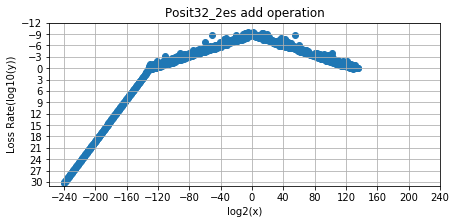

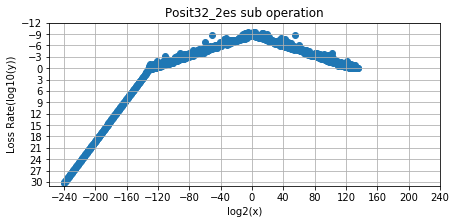

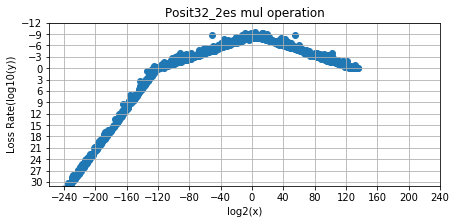

In [8]:
#Posit32_2es
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import math

from pynq import Overlay
from pynq import MMIO
op_list = ["add", "sub", "mul"]
for op in op_list:
    ol = Overlay(f'./bitstream/posit_{op}32.bit')
    myip = MMIO(0x43C00000, 0x10000)

    A_posit32_path = f"./acc_hw_2es/posit32_{op}_A.txt"
    B_posit32_path = f"./acc_hw_2es/posit32_{op}_B.txt"
    O_path = f"./acc_hw_2es/data.txt"
    str_in1 = []
    str_in2 = []
    str_out = []
    loss_rate = []
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])

    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        
        ####################
        myip.write(0, in1)
        myip.write(4, in2)  #一個暫存器4-byte，也就是32-bit。
        result = myip.read(8)
        ####################

        #print(myip.read(0), myip.read(4), myip.read(8))
        
        a = '{:032b}'.format(myip.read(0))
        b = '{:032b}'.format(myip.read(4))
        str_result = '{:032b}'.format(result)
        
        LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, 2))/float(str_out[i])
        loss_rate.append(math.log(LR, 10))
        if (LR>0.95 and LR<1.0001) or LR==float("nan"):
            loss_rate[-1] = float("nan")

    plt.figure(figsize=(7, 3))
    x = np.linspace(-240, 240, 1000)
    
    plt.scatter(x, loss_rate)
    plt.title(f'Posit32_2es {op} operation')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(-240, 241, 40)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.grid()
    plt.show()

In [9]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
import math

def F_P_2es(inout_type, in1, in2, out):
    global counter
    n = 3
    flag = 0
    #in1
    if inout_type&0b1 == 0:
        log_in1 = math.log(abs(posit_str_to_f(in1, 2)), 2)
    else:
        log_in1 = math.log(abs(bin_to_float(in1)), 2)
    #in2
    if inout_type&0b10 == 0:
        log_in2 = math.log(abs(posit_str_to_f(in2, 2)), 2)
    else:
        log_in2 = math.log(abs(bin_to_float(in2)), 2)
    
    if inout_type&0b100 == 0:
        log_out = math.log(abs(posit_str_to_f(out, 2)), 2)
    else:
        log_out = math.log(abs(bin_to_float(out)), 2)
    """
    if(log_in1>-20 and log_in1<20):
        if counter == 0:
            counter += 1
        elif counter != 1:
            counter -= 1
    """
    if (log_in1>-127 and log_in1<128) and (log_in2>-127 and log_in2<128) and (log_out>-127 and log_out<128):
        if counter < 5:
            counter += 1
    else:
        counter = 0
        
    if counter > n:
        flag = 0b111
    elif counter == n:
        flag = 0b100
    elif counter < n:
        flag = 0b000
    elif counter == 0:
        flag = 0b011
    return flag 

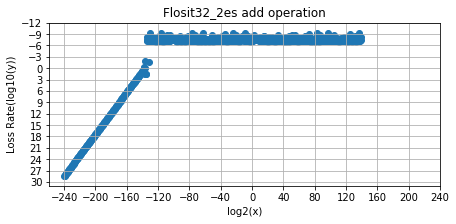

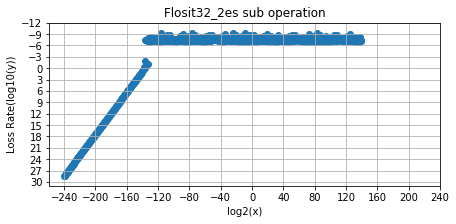

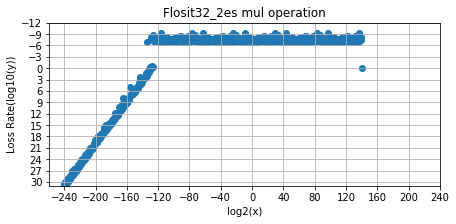

In [11]:
#Flosit32_2es
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    ol = Overlay(f'./bitstream/Flosit_{op}32_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = f"./acc_hw_2es/float32_{op}_A.txt"
    B_float32_path = f"./acc_hw_2es/float32_{op}_B.txt"
    A_posit32_path = f"./acc_hw_2es/posit32_{op}_A.txt"
    B_posit32_path = f"./acc_hw_2es/posit32_{op}_B.txt"
    O_path = f"./acc_hw_2es/data.txt"
    #Posit
    str_in1_P = []
    str_in2_P = []
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_P.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_P.append(str_num_b[0:-1])
    #Float
    str_in1_F = []
    str_in2_F = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_F.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_F.append(str_num_b[0:-1])
    #data
    str_out = []
    with open(O_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
    
    counter = 3
    loss_rate = []
    Flag = 0b111
    for i in range(len(str_in1)):
        in1_F = int("0b"+str_in1_F[i], 2)
        in2_F = int("0b"+str_in2_F[i], 2)
        in1_P = int("0b"+str_in1_P[i], 2)
        in2_P = int("0b"+str_in2_P[i], 2)
        
        myip.write(12, 1)   #start=1
        if Flag == 0b111:
            myip.write(0, Flag)
            myip.write(4, in1_F)
            myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            a = '{:032b}'.format(myip.read(4))
            b = '{:032b}'.format(myip.read(8))
            str_result = '{:032b}'.format(result)
            Flag = F_P_2es(Flag, a, b, str_result)
            LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
            if Flag == 0b011:
                myip.write(0, Flag)
                myip.write(4, in1_F)
                myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
                result = myip.read(16)
                str_result = '{:032b}'.format(result)
                LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, 2))/float(str_out[i])
        elif Flag == 0b000:
            myip.write(0, Flag)
            myip.write(4, in1_P)
            myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            str_result = '{:032b}'.format(result)
            LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, 2))/float(str_out[i])
        elif Flag == 0b100:
            myip.write(0, Flag)
            myip.write(4, in1_P)
            myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            str_result = '{:032b}'.format(result)
            LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
            
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)
        Flag = F_P_2es(Flag, a, b, str_result)
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        
        loss_rate.append(math.log(LR, 10))
        if (LR>0.9 and LR<1.0001) or LR==float("nan"):
            loss_rate[-1] = float("nan")

    plt.figure(figsize=(7, 3))
    x = np.linspace(-240, 240, 1000)
    plt.scatter(x, loss_rate)
    plt.title(f'Flosit32_2es {op} operation')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(-240, 241, 40)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.grid()
    plt.show()

## Flosit32 with es=3: Posit32 part

In [16]:
#Flosit32: Posit32 part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
#op_list = ["add"]
for op in op_list:
    print("====================================================================================================================")
    ol = Overlay(f'./bitstream/Flosit_{op}32_3es_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)

    str_in1 = []
    str_in2 = []
    str_out = []
    A_posit32_path = "./random_float_numbers/random_posit32_3es_A.txt"
    B_posit32_path = "./random_float_numbers/random_posit32_3es_B.txt"
    O_posit32_path = f"./random_float_numbers/random_posit32_3es_AB_{op}.txt"
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2.append(str_num_b[0:-1])
    with open(O_posit32_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
        
    count = 0
    Pass = 1
    for i in range(len(str_in1)):
        in1 = int("0b"+str_in1[i], 2)
        in2 = int("0b"+str_in2[i], 2)
        myip.write(0, 0b000) #輸入Posit, 要輸出Posit, F/P'[2]控制輸出格式, F/P'[1]控制輸入2格式, F/P'[0]控制輸入1格式
        myip.write(4, in1)
        myip.write(8, in2)  #一個暫存器4-byte，也就是32-bit。
        myip.write(12, 1)   #start=1
        #print(myip.read(0), myip.read(4), myip.read(8))

        result = myip.read(16)
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)
        #print("in1 + in2 = out = golden_pattern")
        #print(f'{posit_str_to_f(a, 2)} + {posit_str_to_f(b, 2)} = {posit_str_to_f(str_result, 2)} = {posit_str_to_f(str_out[i], 2)}')
        #print(bin(myip.read(0)))
        #print(f'{str_in1[i]} + {str_in2[i]} = ')
        #print(f'{str_result} = {str_out[i]}')
        #print()
        if (posit_str_to_f(str_result, 3) != posit_str_to_f(str_out[i], 3)):
            Pass = 0
            count += 1
            print(f'{str_in1[i]} {op} {str_in2[i]} = ')
            print(f'{str_result}  =  {str_out[i]}')
            print(f'{posit_str_to_f(str_in1[i], 3)} {op} {posit_str_to_f(str_in2[i], 3)} = ', end = ' ')
            print(f'{posit_str_to_f(str_result, 3)} = {posit_str_to_f(str_out[i], 3)}')
            print()
    print("====================================================================================================================")
    if Pass:
        print("Passed!", end=' ')
    else:
        print("Failed!", end=' ')
    print(f"when op = {op}, error count: {count}")
    print("====================================================================================================================")
    print("\n\n\n\n\n")

10000101110001111001100101111010 add 10001010101010001011010100101100 = 
10000101110001100100001000101111  =  10000101110001100100001000110000
-386715840.0 add -2812250.5 =  -389528096.0 = -389528064.0

10001001000010001010001100011000 add 01111111100010100011110111000110 = 
01111111100010100011110111000110  =  01111111100010100011110111000101
-8247098.0 add 1.8449090431523226e+17 =  1.8449090431523226e+17 = 1.844906294373253e+17

01011100110010000001100100001100 add 10010111001001000110111111011010 = 
10010111001101111001000000111110  =  10010111001101111001000000111111
153.0122299194336 add -5852.504638671875 =  -5699.492431640625 = -5699.4923095703125

01010010010011111101110010010110 add 01111001111101011100001010010011 = 
01111001111101011100001010010101  =  01111001111101011100001010010100
25.247838497161865 add 257698096.0 =  257698128.0 = 257698112.0

10000010000100001100001000001110 add 00111101110001110110101011101000 = 
10000010000100001100001000001110  =  100000100001000011

1022.5691986083984 add -3.334782510995865 =  1019.2344207763672 = 1019.2344055175781

01111111000101001100011111100001 add 10111011011100001000111001001100 = 
01111111000101001100011111100001  =  01111111000101001100011111100000
731158589472768.0 add -2.280164361000061 =  731158589472768.0 = 731158052601856.0

01001001111101000010000000111110 add 10000101001010011111100111111110 = 
10000101001010011111100111111110  =  10000101001010011111100111111111
5.953616976737976 add -897679488.0 =  -897679488.0 = -897679424.0

10111011101000001100100011010111 add 01110111011010010000001010110110 = 
01110111011010010000001010110010  =  01110111011010010000001010110001
-2.1859677135944366 add 11829595.0 =  11829593.0 = 11829592.5

10000101010111101101100010011001 add 01001001001001110101001000101110 = 
10000101010111101101100010011001  =  10000101010111101101100010011010
-675928512.0 add 5.153597712516785 =  -675928512.0 = -675928448.0

01100001010010000101101111111111 add 1010110110110001110110000

10110101001110110001101001111100  =  10110101001110110001101001111101
-2.434175342321396 add -4.334951758384705 =  -6.769127130508423 = -6.769127070903778

01000010001001001000000100011010 add 10011011100110000110001011111110 = 
10011011100110010010011110001110  =  10011011100110010010011110001111
1.5356487333774567 add -1231.2266235351562 =  -1229.6909790039062 = -1229.6909484863281

10001011100000010100000100100110 add 10010010111010010100101000110001 = 
10001011011110110001001110111010  =  10001011011110110001001110111011
-1567725.625 add -25302.72607421875 =  -1593028.375 = -1593028.3125

10111110101110110011000111001110 add 01111100000000001101101101001100 = 
01111100000000001101101101001100  =  01111100000000001101101101001011
-1.3171928226947784 add 4352454656.0 =  4352454656.0 = 4352453632.0

00111110011100101000001101001010 add 10011001111011000000011100010001 = 
10011001111011000011101010100101  =  10011001111011000011101010100110
0.8059144765138626 add -2127.8895874023438 = 

10000011101101000001011001000111 add 10000010100111111101110111011001 = 
10000010100110110001111100111101  =  10000010100110110001111100111110
-10188867584.0 add -206444920832.0 =  -216633802752.0 = -216633769984.0

10111111100100100010001010010110 add 01111101110001110001110000010000 = 
01111101110001110001110000010000  =  01111101110001110001110000001111
-1.1072899401187897 add 610826977280.0 =  610826977280.0 = 610826846208.0

01000111100100100011000001110011 add 10010000001111011110001100010001 = 
10010000001111011111001000110101  =  10010000001111011111001000110110
3.7855258882045746 add -61575.2333984375 =  -61571.4482421875 = -61571.447265625

10001001110010010010101101010100 add 10101001110000000001011001111101 = 
10001001110010010010101010001100  =  10001001110010010010101010001101
-5092651.0 add -49.997254848480225 =  -5092701.0 = -5092700.75

01100010000000001001100000101001 add 10110000100011001000101000111010 = 
01100001111000110110001001111011  =  011000011110001101100010

10100100001110001110000011110110 add 10001000101001001110111000010110 = 
10001000101001001110110100011101  =  10001000101001001110110100011110
-124.44507789611816 add -11372789.0 =  -11372913.5 = -11372913.0

10101111001010111111010001010011 add 10111011111101001100000010101011 = 
10101110101010101000110001101000  =  10101110101010101000110001101001
-19.313212633132935 add -2.0219675600528717 =  -21.335180282592773 = -21.335180044174194

10111100111101101100011111110010 add 10111110110000011001111010101001 = 
10111001110111000011001101001101  =  10111001110111000011001101001110
-1.7590028941631317 add -1.3109181970357895 =  -3.0699211061000824 = -3.06992107629776

01111110110011010010011000111010 add 10011001110011001111110100101111 = 
01111110110011010010011000111010  =  01111110110011010010011000111001
99284410171392.0 add -2252.0440063476562 =  99284410171392.0 = 99284376616960.0

01010101000001100011111100001101 add 10100011101100110101111100011000 = 
101001011110100111011101101101

-40191197184.0 add -45384802304.0 =  -85576007680.0 = -85575991296.0

10110101100010110111110101011101 add 01101010000111000010100111010101 = 
01101010000110111100001010001101  =  01101010000110111100001010001100
-6.455118358135223 add 8642.614501953125 =  8636.159423828125 = 8636.1591796875

01011101110101111000100011010101 add 10000001100110011111010000110111 = 
10000001100110011111010000110111  =  10000001100110011111010000111000
186.9418125152588 add -10458014679040.0 =  -10458014679040.0 = -10458010484736.0

10111011011111001001010001110001 add 01111001101100000010011110000010 = 
01111001101100000010011110000010  =  01111001101100000010011110000001
-2.256679981946945 add 184711200.0 =  184711200.0 = 184711184.0

01000111111110101010011010101010 add 10010101110010001010010111010011 = 
10010101110010001110010110101000  =  10010101110010001110010110101001
3.9895527958869934 add -9077.635986328125 =  -9073.646484375 = -9073.646240234375

01001011111010010100101011101010 add 0110001010

-4.090316295623779 add 0.8086603134870529 =  -3.2816559970378876 = -3.281655967235565

10000111010110110011011000010010 add 10111011011100110010001110010001 = 
10000111010110110011011000010001  =  10000111010110110011011000010010
-43198392.0 add -2.27511927485466 =  -43198396.0 = -43198392.0

01011110101010110001011010101110 add 10111101111001000010111011000010 = 
01011110100111101101111100001100  =  01011110100111101101111100001011
213.3860740661621 add -1.5271653831005096 =  211.8589096069336 = 211.85890769958496

01000010111111011100100111100011 add 10011101110001100000001111011110 = 
10011101110001111100001101010000  =  10011101110001111100001101010001
1.7478404492139816 add -569.9848937988281 =  -568.237060546875 = -568.2370452880859

01010010010101000001111011011010 add 01100001101010001101110010010100 = 
01100001110110110111110110001011  =  01100001110110110111110110001010
25.314383029937744 add 468.4308166503906 =  493.74520111083984 = 493.7451934814453

10111000000101000101110

-855310.34375 add -687.984619140625 =  -855998.34375 = -855998.3125

01111010110011011010101110000111 add 10101110010000100111111100111111 = 
01111010110011011010101110000111  =  01111010110011011010101110000110
862642624.0 add -22.960983514785767 =  862642624.0 = 862642560.0

10010010111000001101010001101010 add 01001010011011001010010011101000 = 
10010010111000010000011111001111  =  10010010111000010000011111010000
-25573.4482421875 add 6.424391269683838 =  -25567.02392578125 = -25567.0234375

10110101000010010011010001011010 add 10101101000110010001100011100100 = 
10101011101011011011001011111101  =  10101011101011011011001011111110
-6.96404492855072 add -27.607855796813965 =  -34.571900844573975 = -34.571900367736816

10000110110001101000001001000001 add 01101111111110001110101100001110 = 
10000110110001101010001000001000  =  10000110110001101010001000001001
-97250808.0 add 65082.763671875 =  -97185728.0 = -97185720.0

10101100000100010010011110011011 add 01001000110101010101000101

10001100011001111010011110101010 add 10010001001110111000100000101001 = 
10001100010100011000001111101011  =  10001100010100011000001111101100
-836290.6875 add -45341.9599609375 =  -881632.65625 = -881632.625

10011001111001000000111010111101 add 01100000001111011011100010101110 = 
10011010010101111000101110100101  =  10011010010101111000101110100110
-2159.7697143554688 add 286.86070251464844 =  -1872.9090270996094 = -1872.9089965820312

10000101000101111111100101101111 add 10001111011111100000010010001000 = 
10000101000101111111001101100111  =  10000101000101111111001101101000
-973186112.0 add -98811.46875 =  -973284928.0 = -973284864.0

10000111011110111110111011100110 add 01001001001001110110111011011101 = 
10000111011110111110111011100111  =  10000111011110111110111011101000
-34620520.0 add 5.15403538942337 =  -34620516.0 = -34620512.0

01100110111011111001110111011001 add 10000001100110000000111001100111 = 
10000001100110000000111001100111  =  10000001100110000000111001101000
3006

01110000000011011010010111000101 add 10000010111100110010100011001101 = 
10000010111100110010100011010001  =  10000010111100110010100011010010
69029.76953125 add -82506989568.0 =  -82506924032.0 = -82506907648.0

10111110011011000110011010000010 add 10101110011011001111000100010001 = 
10101110000100111011011101111001  =  10101110000100111011011101111010
-1.394140213727951 add -22.297786474227905 =  -23.69192671775818 = -23.6919264793396

Failed! when op = add, error count: 482






10011110100110001011010110101111 sub 10000001100110000111011000100110 = 
01111110011001111000100111011010  =  01111110011001111000100111011001
-435.64514923095703 sub -10868255358976.0 =  10868255358976.0 = 10868251164672.0

01100001100011110110000111101010 sub 10111111001011001101111000001110 = 
01100001100100011100101101111011  =  01100001100100011100101101111010
455.6912384033203 sub -1.2061841785907745 =  456.89742279052734 = 456.8974151611328

01100001010011110010011010101101 sub 1011110100110001000100

01100010000010101000101010100101 sub 00111111001110111001000110111001 = 
01100010000010011010001100110011  =  01100010000010011010001100110010
522.5415802001953 sub 0.9040865376591682 =  521.6374969482422 = 521.6374816894531

01011010000110110010011100110011 sub 01010001011000111001110101010110 = 
01011000110000100011111111011110  =  01011000110000100011111111011101
97.69707012176514 sub 21.556478023529053 =  76.14059257507324 = 76.14059162139893

00111110010011100100100000001001 sub 10110000110010001000010101101000 = 
01001111100111000101111100011001  =  01001111100111000101111100011000
0.7882233336567879 sub -14.433428764343262 =  15.221652150154114 = 15.221652030944824

01100110100011001100000010011110 sub 01000101000111010100000111001110 = 
01100110100011000001110011110110  =  01100110100011000001110011110101
2611.0096435546875 sub 2.557142674922943 =  2608.4525146484375 = 2608.4524536132812

01011000010001100001111000100001 sub 01101100100101011111111010100110 = 
10010011011011000

-31346231607296.0 sub -21.085954189300537 =  -31346231607296.0 = -31346223218688.0

01110100010011100001001101010001 sub 01001010011000011010001100000011 = 
01110100010011100001001011101011  =  01110100010011100001001011101010
1368373.0625 sub 6.381393611431122 =  1368366.6875 = 1368366.625

10110101101111000100100100001111 sub 10111110010000010101101000111011 = 
10110111001010111111001010000000  =  10110111001010111111001010000001
-6.264510214328766 sub -1.4361792355775833 =  -4.828330993652344 = -4.828330934047699

01111000101010110011010101011000 sub 10101010001000010110010111001001 = 
01111000101010110011010101100100  =  01111000101010110011010101100011
44881248.0 sub -46.9563250541687 =  44881296.0 = 44881292.0

10100000000100000010000110001100 sub 10111101101000000101100101110110 = 
10100000000111001110000011011001  =  10100000000111001110000011011010
-253.9836196899414 sub -1.5934087336063385 =  -252.39021110534668 = -252.39020919799805

10111100001001011110001100011010 sub 0100

10001101110101000000001111011101 sub 10110011011110110011110111101011 = 
10001101110101000000011000011111  =  10001101110101000000011000100000
-307184.546875 sub -9.03717291355133 =  -307175.515625 = -307175.5

01000011001001111010111101011111 sub 10110111100110110111100000101100 = 
01001010001011100111001110101100  =  01001010001011100111001110101011
1.7887549251317978 sub -4.39269757270813 =  6.181452512741089 = 6.181452453136444

01000100111100111000001000001001 sub 01111111000001000101111010111100 = 
10000000111110111010000101000100  =  10000000111110111010000101000101
2.475601464509964 sub 358353817567232.0 =  -358353817567232.0 = -358353549131776.0

01111110010010101100111010000100 sub 01111001000100000010101001101000 = 
01111110010010101100111001100000  =  01111110010010101100111001011111
5883308277760.0 sub 75584320.0 =  5883232780288.0 = 5883230683136.0

10011010110001100111110100000110 sub 10000010001101000001010100101011 = 
01111101110010111110101011010101  =  01111101110010

01011100110111000111111111001110 sub 01001000100101011100111101100110 = 
01011100101101111101000101010011  =  01011100101101111101000101010010
155.56240463256836 sub 4.585195899009705 =  150.97720909118652 = 150.9772071838379

10000001010110011110010100010011 sub 10001110011101101100011001010111 = 
10000001010110011110010100010011  =  10000001010110011110010100010100
-41897087205376.0 sub -201331.3203125 =  -41897087205376.0 = -41897070428160.0

10111110000010100111001110111100 sub 10000111000001000111011101011000 = 
01111000111110111000100010101000  =  01111000111110111000100010100111
-1.4897928833961487 sub -65938080.0 =  65938080.0 = 65938076.0

10101011111010101010101111000100 sub 10000001110111001101011001011001 = 
01111110001000110010100110100111  =  01111110001000110010100110100110
-32.66653251647949 sub -2416362651648.0 =  2416362651648.0 = 2416361603072.0

01110011001011100000100000101101 sub 10110011011100001110100101110101 = 
01110011001011100000100101010001  =  011100110010

01110001110001100110000101100001 sub 01101100111111000010001100100001 = 
01110001100101101001111100101111  =  01110001100101101001111100101110
232642.7578125 sub 24452.39111328125 =  208190.3671875 = 208190.359375

10011011011010010101000011000010 sub 01000101010001011000011101100010 = 
10011011011001111111111101100000  =  10011011011001111111111101100001
-1325.3690795898438 sub 2.6357985138893127 =  -1328.0048828125 = -1328.0048522949219

01010100001110100100000010011011 sub 01111101010000111110110111001010 = 
10000010101111000001001000110110  =  10000010101111000001001000110111
33.82038640975952 sub 145876123648.0 =  -145876123648.0 = -145876090880.0

10000010001001111101011100001101 sub 10100010001011000100010101000011 = 
10000010001001111101011100001101  =  10000010001001111101011100001110
-757288271872.0 sub -186.4661808013916 =  -757288271872.0 = -757288140800.0

10011011101100000000010110001000 sub 01000111110011011101101100000000 = 
10011011101011100001001000010001  =  10011011

10111100101011011011001101011011 sub 10101111011110110110100001101010 = 
01010000000011110111001011001100  =  01010000000011110111001011001011
-1.8303705006837845 sub -18.071752071380615 =  16.241381645202637 = 16.241381406784058

01001000000111111001100111110011 sub 01111010100110000101101100110001 = 
10000101011001111010010011001111  =  10000101011001111010010011010000
4.123442828655243 sub 639028288.0 =  -639028288.0 = -639028224.0

01000110100010110111110100101010 sub 10110000111010010001011111001101 = 
01010000010111001110001110111111  =  01010000010111001110001110111110
3.2724393010139465 sub -14.178961157798767 =  17.45140051841736 = 17.45140027999878

10011011011011000011100111010100 sub 10001010000001011011001100110001 = 
01110101111110100010001110010011  =  01110101111110100010001110010010
-1319.5482177734375 sub -4147609.875 =  4146290.375 = 4146290.25

01001110001000100100001100011010 sub 01111110001000100100100111001000 = 
10000001110111011011011000111000  =  1000000111011

504.1755676269531 sub -107103.59765625 =  107607.7734375 = 107607.76953125

10110111001011100100111100000011 sub 10010111111111100010001001100010 = 
01101000000000010100001101101000  =  01101000000000010100001101100111
-4.819106876850128 sub -4110.925537109375 =  4106.1064453125 = 4106.1063232421875

10000010111000101010000111001110 sub 10000111010010000011100100010011 = 
10000010111000101010110101001010  =  10000010111000101010110101001011
-100253073408.0 sub -48176052.0 =  -100204904448.0 = -100204888064.0

01101001000100111110001110011011 sub 01111110011101011010110011110101 = 
10000001100010100101001100001011  =  10000001100010100101001100001100
6303.1126708984375 sub 14754240266240.0 =  -14754240266240.0 = -14754236071936.0

01010011111001011011101111011110 sub 01111110101000010100011101010111 = 
10000001010111101011100010101001  =  10000001010111101011100010101010
31.58959150314331 sub 36590286012416.0 =  -36590286012416.0 = -36590269235200.0

01110100010000000001000011100000 sub

00111100101101011011111011111001 sub 10011001000101110100101001010011 = 
01100110111010001101101101011011  =  01100110111010001101101101011010
0.588743157684803 sub -2978.8386840820312 =  2979.4274291992188 = 2979.4273681640625

01100010010101000011000001010110 sub 01010011110011100001000101010011 = 
01100010001101001111100000010001  =  01100010001101001111100000010000
596.1888122558594 sub 31.219807386398315 =  564.9690093994141 = 564.968994140625

10010101000110111000100110001010 sub 01100000001101100001110101111011 = 
10010101000010011101100010011110  =  10010101000010011101100010011111
-11847.40380859375 sub 283.05757904052734 =  -12130.46142578125 = -12130.461181640625

10111100011111110110100101101010 sub 10000100000001100100011010010111 = 
01111011111110011011100101101001  =  01111011111110011011100101101000
-1.8755744397640228 sub -4189677824.0 =  4189677824.0 = 4189677568.0

01100111001011111011010100101000 sub 00111111101011100010111011001000 = 
011001110010111101110111101101

01000001001111101100010010111000 mul 01111001000010110010110100101001 = 
01111001001101101000000001101100  =  01111001001101101000000001101011
1.3112972974777222 mul 72968520.0 =  95683424.0 = 95683416.0

10110010110101110011001111111110 mul 10110111101110100001011101110010 = 
01010101100000101111011110110111  =  01010101100000101111011110110110
-10.318725824356079 mul -4.273079752922058 =  44.09273862838745 = 44.09273815155029

10000101010111101101100010011001 mul 01001001001001110101001000101110 = 
10000100001100000101111010010000  =  10000100001100000101111010010001
-675928512.0 mul 5.153597712516785 =  -3483463680.0 = -3483463424.0

01011110000000011001101111111100 mul 01011100011010011110010110000110 = 
01101101010100000100111101110000  =  01101101010100000100111101101111
192.20116424560547 mul 141.2370719909668 =  27145.9296875 = 27145.92919921875

01100001010010000101101111111111 mul 10101101101100011101100001111111 = 
10010101011010011010100101001010  =  10010101011010011010100

10110001011011101011101011010011 mul 10001111111100101110001101010101 = 
01110011101110011101100001111110  =  01110011101110011101100001111101
-13.134923577308655 mul -68892.66796875 =  904899.9375 = 904899.90625

10111011001000011011001111000101 mul 10110111101010100100000010011010 = 
01001101010001101010100100000010  =  01001101010001101010100100000001
-2.434175342321396 mul -4.334951758384705 =  10.552032709121704 = 10.552032589912415

00111100110001010010100001000000 mul 10001010111101011111010000111010 = 
10001011110000101011101100000001  =  10001011110000101011101100000010
0.5962681770324707 mul -2179448.75 =  -1299535.9375 = -1299535.875

00111110011100101000001101001010 mul 10011001111011000000011100010001 = 
10011010101001101000110100101110  =  10011010101001101000110100101111
0.8059144765138626 mul -2127.8895874023438 =  -1714.8970336914062 = -1714.8970031738281

10010010001111010001101011111000 mul 01011000000111011000001110000110 = 
10001011000100001010110100100111  =  1000

10001011111101010110000111011111 mul 10110010101010111110111111100100 = 
01110111011000110010100011010100  =  01110111011000110010100011010011
-1092066.0625 mul -10.656741619110107 =  11637866.0 = 11637865.5

01111111000011000111010010000000 mul 10010001000110011111100000101011 = 
10000000001111101101100001010111  =  10000000001111101101100001011000
500587028283392.0 mul -47489.9580078125 =  -2.3772883951772762e+19 = -2.3772813583028584e+19

01110001110001101000010011000001 mul 01111100100110101010000110010000 = 
01111111010001000001110100110001  =  01111111010001000001110100110000
232713.5078125 mul 24328601600.0 =  5661595824816128.0 = 5661591529848832.0

10000110001011010000100111000111 mul 00111100101110101100011001100100 = 
10000110100001101000111100101110  =  10000110100001101000111100101111
-221209488.0 mul 0.5911987125873566 =  -130778768.0 = -130778760.0

01101001100000011011001011011011 mul 01110111011001010100010001110110 = 
01111101000011100100110011101000  =  0111110100001

01100011001011111011110001000110 mul 10001110101011001011100010111010 = 
10000110011110001101110011010010  =  10000110011110001101110011010011
815.7354431152344 mul -173710.546875 =  -141701856.0 = -141701840.0

10000100110011111101011001011001 mul 10110101100011000011100110101100 = 
01111100010001110000101001010010  =  01111100010001110000101001010001
-1477759872.0 mul -6.452244997024536 =  9534869504.0 = 9534867456.0

01001001010110000010000010100101 mul 01110010101010111111101000010111 = 
01110101000111011110011011100000  =  01110101000111011110011011011111
5.344248116016388 mul 438248.359375 =  2342108.0 = 2342107.875

01000000001111011100111011100010 mul 01011000111110010010011100001001 = 
01011001010001011111111111010101  =  01011001010001011111111111010100
1.0603595077991486 mul 79.57203006744385 =  84.3749589920044 = 84.37495803833008

10001011010111100010100100000000 mul 01110011000100001101110111101011 = 
10000010000100001010100001010110  =  10000010000100001010100001010111
-

-11957.982177734375 mul -62.46215486526489 =  746921.34375 = 746921.3125

01000101101111111111011111101001 mul 00111110010100001111001100111010 = 
01000100100010100010100001101111  =  01000100100010100010100001101110
2.874938279390335 mul 0.7895264178514481 =  2.269839733839035 = 2.2698397040367126

01110110111000010010010001110110 mul 10010111101000110011000100011100 = 
10000011001110001111010010010010  =  10000011001110001111010010010011
7883037.5 mul -4838.46533203125 =  -38141804544.0 = -38141796352.0

10101011011111101001110011100100 mul 01000100000010001100001100010110 = 
10100111011101001011111001100001  =  10100111011101001011111001100010
-36.04334831237793 mul 2.0171133875846863 =  -72.70352077484131 = -72.70351982116699

01111111011001011101000111001001 mul 10111011010000000000001000110001 = 
10000000100001100001011011101101  =  10000000100001100001011011101110
2.4566542918221824e+16 mul -2.3749832808971405 =  -5.834513785133466e+16 = -5.834510349159629e+16

10111111111111000

9599.2900390625 mul -21509948.0 =  -206480244736.0 = -206480211968.0

01000000101001101111101110100011 mul 10000100010001011101010000110011 = 
10000100001001110111100001011001  =  10000100001001110111100001011010
1.1630692929029465 mul -3123432704.0 =  -3632768768.0 = -3632768512.0

10001101101110110111101010011100 mul 01100101011011010101101001011101 = 
10000101011101001111101000001111  =  10000101011101001111101000010000
-332309.5625 mul 1754.7059631347656 =  -583105600.0 = -583105536.0

01010001001010000111100111110010 mul 10011100010101010110000111011100 = 
10010011101000101101000000101111  =  10010011101000101101000000110000
20.632442951202393 mul -938.6177368164062 =  -19365.97705078125 = -19365.9765625

01110011001110110101001011110101 mul 10101010001000000111000100001110 = 
10000111100110001000000001111100  =  10000111100110001000000001111101
645783.65625 mul -46.986199378967285 =  -30342920.0 = -30342918.0

10001010101101100110011100001011 mul 10000100010110000101001010100111 

10000100101011001010010101110011 mul 01100010001010101001011001101110 = 
10000010000011011000100001110110  =  10000010000011011000100001110111
-1772963456.0 mul 554.5876159667969 =  -983263608832.0 = -983263477760.0

01001100001011100101000001111000 mul 01100010000101000110101111000000 = 
01101000001011001000000001101110  =  01101000001011001000000001101101
8.361830711364746 mul 532.4208984375 =  4452.013427734375 = 4452.0133056640625

10000000110100110010111010001111 mul 01111111101110110001011100011000 = 
10000000000000001101110000000110  =  10000000000000001101110000000111
-2027895652352000.0 mul 1.2786141554569904e+19 =  -2.593106067826866e+34 = -2.592599007586775e+34

01101010111000101111011101101010 mul 10111111101010101010111110100010 = 
10010100110111110111011110001101  =  10010100110111110111011110001110
11823.46337890625 mul -1.0833143889904022 =  -12808.528076171875 = -12808.52783203125

10101101011111001000001101001011 mul 01001111011011111011110100011001 = 
100111101111100

10011111101111000001010111110100 mul 01101010101000010000011110100101 = 
10001010100000101101100100011001  =  10001010100000101101100100011010
-289.9571228027344 mul 10768.477783203125 =  -3122396.875 = -3122396.75

01000100110010010011010100010100 mul 01000001101111011001000100101101 = 
01000110110111100101001100011001  =  01000110110111100101001100011000
2.392983078956604 mul 1.4351241141557693 =  3.4342277348041534 = 3.434227705001831

01000010000101101010011100111000 mul 10010110111010100011011110010000 = 
10010101101001101110110101001000  =  10010101101001101110110101001001
1.5221222639083862 mul -6318.263671875 =  -9617.169921875 = -9617.169677734375

01000000010110001010010000101010 mul 01000011100100101100100110100000 = 
01000100000111010100111011100011  =  01000100000111010100111011100010
1.0865637362003326 mul 1.8933472633361816 =  2.0572424829006195 = 2.057242453098297

01000100111001111000000111110111 mul 10011011111000011101000111110111 = 
10011001011001110011111001000100 

10001010011001101010001100110100  =  10001010011001101010001100110101
-11847.40380859375 mul 283.05757904052734 =  -3353497.5 = -3353497.375

10111100011111110110100101101010 mul 10000100000001100100011010010111 = 
01111100001101010001100000011000  =  01111100001101010001100000010111
-1.8755744397640228 mul -4189677824.0 =  7858053120.0 = 7858052096.0

10000010001010000101000010011110 mul 10110110010100101100001010110111 = 
01111110001111100011100001101110  =  01111110001111100011100001101101
-753209180160.0 mul -5.676716387271881 =  4275755286528.0 = 4275754237952.0

10001010011001101001010101000001 mul 01111110110001100011101110100111 = 
10000000001100000101101101011000  =  10000000001100000101101101011001
-3353943.875 mul 84075293442048.0 =  -2.8198388346854887e+20 = -2.8198332051859544e+20

10110011111100111100001011000011 mul 10111011011101110001101001010101 = 
01010000100101101100010111001001  =  01010000100101101100010111001000
-8.095618844032288 mul -2.2673772275447845 =  18.35

In [17]:
def F_P_3es(inout_type, in1, in2, out):
    global counter
    n = 5
    flag = 0
    #in1
    if inout_type&0b1 == 0:
        log_in1 = math.log(abs(posit_str_to_f(in1, 3)), 2)
    else:
        log_in1 = math.log(abs(bin_to_float(in1)), 2)
    #in2
    if inout_type&0b10 == 0:
        log_in2 = math.log(abs(posit_str_to_f(in2, 3)), 2)
    else:
        log_in2 = math.log(abs(bin_to_float(in2)), 2)
    
    if inout_type&0b100 == 0:
        log_out = math.log(abs(posit_str_to_f(out, 3)), 2)
    else:
        log_out = math.log(abs(bin_to_float(out)), 2)
    
    #counter
    """
    if(log_in1>-20 and log_in1<20):
        if counter == 0:
            counter += 1
        elif counter != 1:
            counter -= 1
    """
    if (log_in1>-127 and log_in1<128) and (log_in2>-127 and log_in2<128) and (log_out>-127 and log_out<128):
        if counter < 10:
            counter += 1
    else:
        counter = 0
        
    if counter > n:
        flag = 0b111
    elif counter == n:
        flag = 0b100
    elif counter < n:
        flag = 0b000
    elif counter == 0:
        flag = 0b011
    return flag 

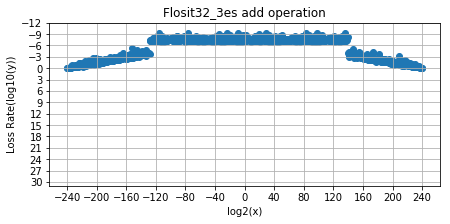

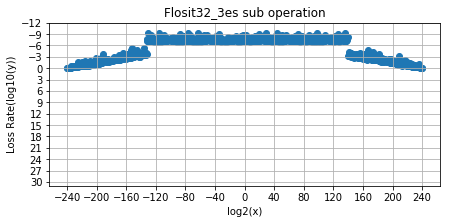

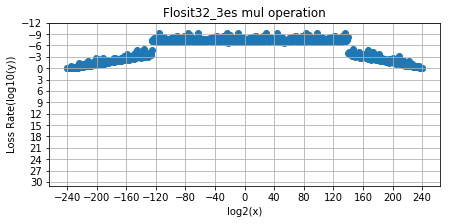

In [18]:
#Flosit32_3es
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
#op_list = ["add"]
for op in op_list:
    ol = Overlay(f'./bitstream/Flosit_{op}32_3es_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = f"./acc_hw_3es/float32_{op}_A.txt"
    B_float32_path = f"./acc_hw_3es/float32_{op}_B.txt"
    A_posit32_path = f"./acc_hw_3es/posit32_{op}_A.txt"
    B_posit32_path = f"./acc_hw_3es/posit32_{op}_B.txt"
    O_path = f"./acc_hw_3es/data.txt"
    #Posit
    str_in1_P = []
    str_in2_P = []
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_P.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_P.append(str_num_b[0:-1])
    #Float
    str_in1_F = []
    str_in2_F = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_F.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_F.append(str_num_b[0:-1])
    #data
    str_out = []
    with open(O_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
    
    counter = 3
    loss_rate = []
    Flag = 0b000
    for i in range(len(str_in1_F)):
        in1_F = int("0b"+str_in1_F[i], 2)
        in2_F = int("0b"+str_in2_F[i], 2)
        in1_P = int("0b"+str_in1_P[i], 2)
        in2_P = int("0b"+str_in2_P[i], 2)
        
        myip.write(12, 1)   #start=1
        if Flag == 0b111:
            myip.write(0, Flag)
            myip.write(4, in1_F)
            myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            a = '{:032b}'.format(myip.read(4))
            b = '{:032b}'.format(myip.read(8))
            str_result = '{:032b}'.format(result)
            Flag = F_P_3es(Flag, a, b, str_result)
            LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
            if Flag == 0b011:
                myip.write(0, Flag)
                myip.write(4, in1_F)
                myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
                result = myip.read(16)
                str_result = '{:032b}'.format(result)
                LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, 3))/float(str_out[i])
        elif Flag == 0b000:
            myip.write(0, Flag)
            myip.write(4, in1_P)
            myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            str_result = '{:032b}'.format(result)
            LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, 3))/float(str_out[i])
        elif Flag == 0b100:
            myip.write(0, Flag)
            myip.write(4, in1_P)
            myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            str_result = '{:032b}'.format(result)
            LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
            
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)
        Flag = F_P_3es(Flag, a, b, str_result)
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))
        if LR==0:
            LR=1E-12
        loss_rate.append(math.log(LR, 10))
        """
        if LR>20:
            print(i)
            print(a,b)
            print(float(str_out[i]))
            print(str_result)
            print(Flag)
            print()
        """
        
    plt.figure(figsize=(7, 3))
    x = np.linspace(-240, 240, 1000)
    
    plt.scatter(x, loss_rate)
    plt.title(f'Flosit32_3es {op} operation')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(-240, 241, 40)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.grid()
    plt.show()

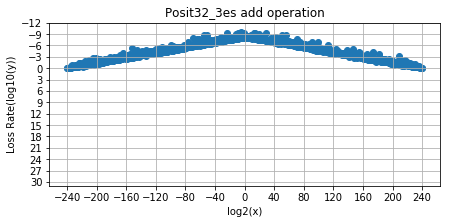

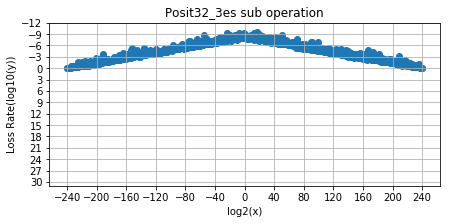

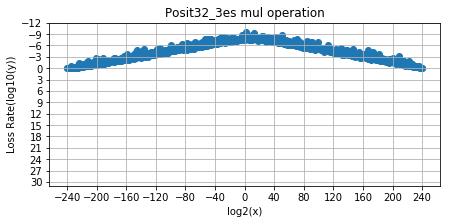

In [19]:
#Flosit32: Posit32_3es part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
for op in op_list:
    ol = Overlay(f'./bitstream/Flosit_{op}32_3es_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = f"./acc_hw_3es/float32_{op}_A.txt"
    B_float32_path = f"./acc_hw_3es/float32_{op}_B.txt"
    A_posit32_path = f"./acc_hw_3es/posit32_{op}_A.txt"
    B_posit32_path = f"./acc_hw_3es/posit32_{op}_B.txt"
    O_path = f"./acc_hw_3es/data.txt"
    #Posit
    str_in1_P = []
    str_in2_P = []
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_P.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_P.append(str_num_b[0:-1])
    #Float
    str_in1_F = []
    str_in2_F = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_F.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_F.append(str_num_b[0:-1])
    #data
    str_out = []
    with open(O_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
    
    counter = 3
    loss_rate = []
    for i in range(len(str_in1_F)):
        in1_F = int("0b"+str_in1_F[i], 2)
        in2_F = int("0b"+str_in2_F[i], 2)
        in1_P = int("0b"+str_in1_P[i], 2)
        in2_P = int("0b"+str_in2_P[i], 2)
        
        myip.write(12, 1)   #start=1
        myip.write(0, 0b000)
        myip.write(4, in1_P)
        myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
        result = myip.read(16)
        str_result = '{:032b}'.format(result)
        LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, 3))/float(str_out[i])
            
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))
        if LR==0:
            LR=1E-12
        loss_rate.append(math.log(LR, 10))
        """
        if loss_rate[-1]>-2:
            print(i)
            print(str_in1_P[i], str_in2_P[i])
            print(a,b)
            print(posit_str_to_f(a, 3), posit_str_to_f(b, 3), posit_str_to_f(str_result, 3))
            print(float(str_out[i]))
            print(str_result)
            print(bin(Flag))
            print(f"log10({LR}) = {loss_rate[-1]} = ({float(str_out[i])} - {posit_str_to_f(str_result, 3)})/{float(str_out[i])}")
            print()
        """
    plt.figure(figsize=(7, 3))
    x = np.linspace(-240, 240, 1000)
    
    plt.scatter(x, loss_rate)
    plt.title(f'Posit32_3es {op} operation')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(-240, 241, 40)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.grid()
    plt.show()

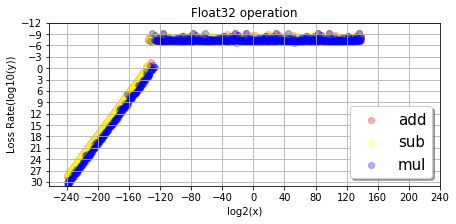

In [30]:
#Flosit32: Float32 part
from pynq import Overlay
from pynq import MMIO
import math
op_list = ["add", "sub", "mul"]
#op_list = ["mul"]
plt.figure(figsize=(7, 3))
for op in op_list:
    ol = Overlay(f'./bitstream/Flosit_{op}32_3es_with_Converter.bit')
    myip = MMIO(0x43C00000, 0x10000)
    
    A_float32_path = f"./acc_hw_3es/float32_{op}_A.txt"
    B_float32_path = f"./acc_hw_3es/float32_{op}_B.txt"
    A_posit32_path = f"./acc_hw_3es/posit32_{op}_A.txt"
    B_posit32_path = f"./acc_hw_3es/posit32_{op}_B.txt"
    O_path = f"./acc_hw_3es/data.txt"
    #Posit
    str_in1_P = []
    str_in2_P = []
    with open(A_posit32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_P.append(str_num_a[0:-1])
    with open(B_posit32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_P.append(str_num_b[0:-1])
    #Float
    str_in1_F = []
    str_in2_F = []
    with open(A_float32_path, 'r') as fa:
        for str_num_a in fa:
            str_in1_F.append(str_num_a[0:-1])
    with open(B_float32_path, 'r') as fb:
        for str_num_b in fb:
            str_in2_F.append(str_num_b[0:-1])
    #data
    str_out = []
    with open(O_path, 'r') as fo:
        for str_num_out in fo:
            str_out.append(str_num_out[0:-1])
    
    counter = 3
    loss_rate = []
    Flag = 0b111
    for i in range(len(str_in1_F)):
        in1_F = int("0b"+str_in1_F[i], 2)
        in2_F = int("0b"+str_in2_F[i], 2)
        in1_P = int("0b"+str_in1_P[i], 2)
        in2_P = int("0b"+str_in2_P[i], 2)
        
        myip.write(12, 1)   #start=1
        myip.write(0, 0b111)
        myip.write(4, in1_F)
        myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
        result = myip.read(16)
        str_result = '{:032b}'.format(result)
        LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
            
        a = '{:032b}'.format(myip.read(4))
        b = '{:032b}'.format(myip.read(8))
        str_result = '{:032b}'.format(result)
        #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))

        loss_rate.append(math.log(LR, 10))
        
        if loss_rate[-1] == 0:
            loss_rate[-1] = float("nan")
        """
        if math.log(float(str_out[i]))<-140:
            print(i)
            print(str_in1_F[i], str_in2_F[i])
            print(a, b, str_result)
            print(bin_to_float(a), bin_to_float(b), bin_to_float(str_result))
            print(float(str_out[i]))
            print(bin(Flag))
            print(f"log10({LR}) = {loss_rate[-1]} = ({float(str_out[i])} - {bin_to_float(str_result)})/{float(str_out[i])}")
            print()
        """
        
    
    x = np.linspace(-240, 240, 1000)
    color = ['red', 'yellow', 'blue']
    plt.scatter(x, loss_rate, c=color[op_list.index(op)], label=f'{op}', alpha = 0.3)

plt.title(f'Float32 operation')
plt.xlabel('log2(x)')
plt.ylabel('Loss Rate(log10(y))')
plt.xticks([i for i in range(-240, 241, 40)])
plt.yticks([i for i in range(-12, 31, 3)])
plt.ylim(31, -12)
plt.legend(loc='lower right',fontsize=15,shadow=True)
plt.grid()
plt.show()

In [18]:
def F_P_Nes(es, inout_type, in1, in2, out):
    global counter
    n = 5
    flag = 0
    #in1
    if inout_type&0b1 == 0:
        log_in1 = math.log(abs(posit_str_to_f(in1, es)), 2)
    else:
        log_in1 = math.log(abs(bin_to_float(in1)), 2)
    #in2
    if inout_type&0b10 == 0:
        log_in2 = math.log(abs(posit_str_to_f(in2, es)), 2)
    else:
        log_in2 = math.log(abs(bin_to_float(in2)), 2)
    #out
    if inout_type&0b100 == 0:
        log_out = math.log(abs(posit_str_to_f(out, es)), 2)
    else:
        log_out = math.log(abs(bin_to_float(out)), 2)
    #counter
    if (log_in1>-126 and log_in1<128) and (log_in2>-126 and log_in2<128) and (log_out>-126 and log_out<128):
        if counter < 10:
            counter += 1
    else:
        if counter==0:
            counter += 1
        elif (counter < n-1):
            counter += 1
        elif (counter == n-1):
            counter = counter
        else:
            counter = 0
    #Flag
    if counter > n:
        flag = 0b111
    elif counter == n:
        flag = 0b100
    elif counter < n:
        if counter == 0:
            flag = 0b011
        else:
            flag = 0b000
    return flag 




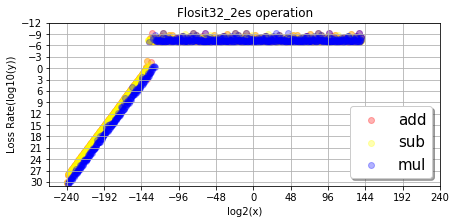

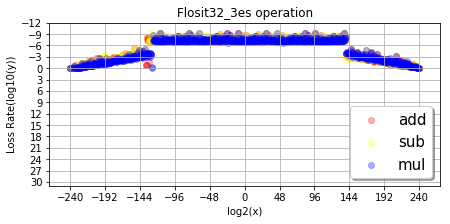

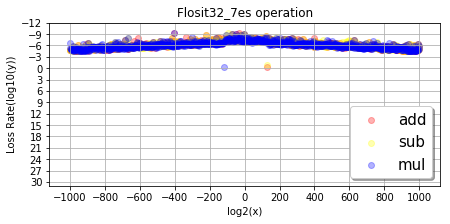

In [27]:
#Flosit32_7es
from pynq import Overlay
from pynq import MMIO
import matplotlib.pyplot as plt
import math
import numpy as np
op_list = ["add", "sub", "mul"]
#op_list = ["add"]
op_list = ["add", "sub", "mul"]
es_list = [2, 3, 7]
for es in es_list:
    min = -(2**es*30)
    max = 2**es*30
    if es==2:
        min = -(2**3*30)
        max = 2**3*30
    if (min<-1000) and (max>1000):
        min = -1000.5
        max = 1000.5
    plt.figure(figsize=(7, 3))
    for op in op_list:
        ol = Overlay(f'./bitstream/Flosit_{op}32_{es}es_with_Converter.bit')
        myip = MMIO(0x43C00000, 0x10000)

        A_float32_path = f"./acc_hw_{es}es/float32_{op}_A.txt"
        B_float32_path = f"./acc_hw_{es}es/float32_{op}_B.txt"
        A_posit32_path = f"./acc_hw_{es}es/posit32_{op}_A.txt"
        B_posit32_path = f"./acc_hw_{es}es/posit32_{op}_B.txt"
        O_path = f"./acc_hw_{es}es/data.txt"
        #Posit
        str_in1_P = []
        str_in2_P = []
        with open(A_posit32_path, 'r') as fa:
            for str_num_a in fa:
                str_in1_P.append(str_num_a[0:-1])
        with open(B_posit32_path, 'r') as fb:
            for str_num_b in fb:
                str_in2_P.append(str_num_b[0:-1])
        #Float
        str_in1_F = []
        str_in2_F = []
        with open(A_float32_path, 'r') as fa:
            for str_num_a in fa:
                str_in1_F.append(str_num_a[0:-1])
        with open(B_float32_path, 'r') as fb:
            for str_num_b in fb:
                str_in2_F.append(str_num_b[0:-1])
        #data
        str_out = []
        with open(O_path, 'r') as fo:
            for str_num_out in fo:
                str_out.append(str_num_out[0:-1])

        counter = 3
        loss_rate = []
        Flag = 0b000
        for i in range(len(str_in1_F)):
            in1_F = int("0b"+str_in1_F[i], 2)
            in2_F = int("0b"+str_in2_F[i], 2)
            in1_P = int("0b"+str_in1_P[i], 2)
            in2_P = int("0b"+str_in2_P[i], 2)

            myip.write(12, 1)   #start=1
            if Flag == 0b111:
                myip.write(0, Flag)
                myip.write(4, in1_F)
                myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
                result = myip.read(16)
                a = '{:032b}'.format(myip.read(4))
                b = '{:032b}'.format(myip.read(8))
                str_result = '{:032b}'.format(result)
                Flag = F_P_Nes(es, Flag, a, b, str_result)
                LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])
                if Flag == 0b011:
                    myip.write(0, Flag)
                    myip.write(4, in1_F)
                    myip.write(8, in2_F)  #一個暫存器4-byte，也就是32-bit。
                    result = myip.read(16)
                    str_result = '{:032b}'.format(result)
                    LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, es))/float(str_out[i])
            elif Flag == 0b000:
                myip.write(0, Flag)
                myip.write(4, in1_P)
                myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
                result = myip.read(16)
                str_result = '{:032b}'.format(result)
                LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, es))/float(str_out[i])
            elif Flag == 0b100:
                myip.write(0, Flag)
                myip.write(4, in1_P)
                myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
                result = myip.read(16)
                str_result = '{:032b}'.format(result)
                LR =  abs(float(str_out[i]) - bin_to_float(str_result))/float(str_out[i])

            a = '{:032b}'.format(myip.read(4))
            b = '{:032b}'.format(myip.read(8))
            str_result = '{:032b}'.format(result)

            Flag = F_P_Nes(es, Flag, a, b, str_result)
            #print(i, es, Flag, a, b, str_result, '\n', str_in1_F[i], str_in2_F[i],)
            #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))
            if LR==0:
                LR=1E-12
            loss_rate.append(math.log(LR, 10))
            if (LR>0.95 and LR<1.0001) or LR==float("nan"):
                loss_rate[-1] = float("nan")
            """
            if LR>20:
                print(i)
                print(a,b)
                print(float(str_out[i]))
                print(str_result)
                print(Flag)
                print()
            """


        x = np.linspace(int(min), int(max), 1000)
        color = ['red', 'yellow', 'blue']
        plt.scatter(x, loss_rate, c=color[op_list.index(op)], label=f'{op}', alpha = 0.3)

    plt.title(f'Flosit32_{es}es operation')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(int(min), int(max)+1, int(max)//5)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.legend(loc='lower right',fontsize=15,shadow=True)
    plt.grid()
    plt.show()

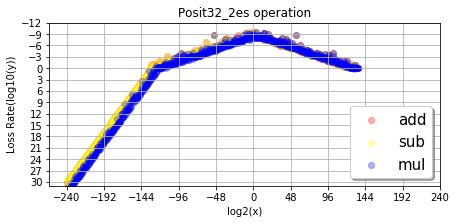

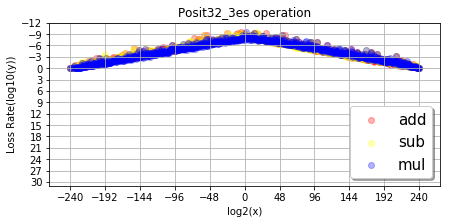

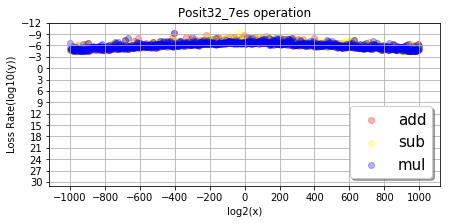

In [28]:
#Flosit32: Posit32_Nes part
from pynq import Overlay
from pynq import MMIO

op_list = ["add", "sub", "mul"]
es_list = [2, 3, 7]
for es in es_list:
    min = -(2**es*30)
    max = 2**es*30
    if es==2:
        min = -(2**3*30)
        max = 2**3*30
    if (min<-1000) and (max>1000):
        min = -1000.5
        max = 1000.5
    plt.figure(figsize=(7, 3))
    for op in op_list:
        ol = Overlay(f'./bitstream/Flosit_{op}32_{es}es_with_Converter.bit')
        myip = MMIO(0x43C00000, 0x10000)

        A_float32_path = f"./acc_hw_{es}es/float32_{op}_A.txt"
        B_float32_path = f"./acc_hw_{es}es/float32_{op}_B.txt"
        A_posit32_path = f"./acc_hw_{es}es/posit32_{op}_A.txt"
        B_posit32_path = f"./acc_hw_{es}es/posit32_{op}_B.txt"
        O_path = f"./acc_hw_{es}es/data.txt"
        #Posit
        str_in1_P = []
        str_in2_P = []
        with open(A_posit32_path, 'r') as fa:
            for str_num_a in fa:
                str_in1_P.append(str_num_a[0:-1])
        with open(B_posit32_path, 'r') as fb:
            for str_num_b in fb:
                str_in2_P.append(str_num_b[0:-1])
        #Float
        str_in1_F = []
        str_in2_F = []
        with open(A_float32_path, 'r') as fa:
            for str_num_a in fa:
                str_in1_F.append(str_num_a[0:-1])
        with open(B_float32_path, 'r') as fb:
            for str_num_b in fb:
                str_in2_F.append(str_num_b[0:-1])
        #data
        str_out = []
        with open(O_path, 'r') as fo:
            for str_num_out in fo:
                str_out.append(str_num_out[0:-1])

        counter = 3
        loss_rate = []
        for i in range(len(str_in1_F)):
            in1_F = int("0b"+str_in1_F[i], 2)
            in2_F = int("0b"+str_in2_F[i], 2)
            in1_P = int("0b"+str_in1_P[i], 2)
            in2_P = int("0b"+str_in2_P[i], 2)

            myip.write(12, 1)   #start=1
            myip.write(0, 0b000)
            myip.write(4, in1_P)
            myip.write(8, in2_P)  #一個暫存器4-byte，也就是32-bit。
            result = myip.read(16)
            str_result = '{:032b}'.format(result)
            LR =  abs(float(str_out[i]) - posit_str_to_f(str_result, es))/float(str_out[i])

            a = '{:032b}'.format(myip.read(4))
            b = '{:032b}'.format(myip.read(8))
            str_result = '{:032b}'.format(result)
            #print(myip.read(0), myip.read(4), myip.read(8), myip.read(12), myip.read(16), myip.read(20))
            if LR==0:
                LR=1E-12
            loss_rate.append(math.log(LR, 10))
            if (LR>0.95 and LR<1.0001) or LR==float("nan"):
                loss_rate[-1] = float("nan")
            """
            if loss_rate[-1]>-2:
                print(i)
                print(str_in1_P[i], str_in2_P[i])
                print(a,b)
                print(posit_str_to_f(a, 3), posit_str_to_f(b, 3), posit_str_to_f(str_result, 3))
                print(float(str_out[i]))
                print(str_result)
                print(bin(Flag))
                print(f"log10({LR}) = {loss_rate[-1]} = ({float(str_out[i])} - {posit_str_to_f(str_result, 3)})/{float(str_out[i])}")
                print()
            """
        
        x = np.linspace(int(min), int(max), 1000)
        color = ['red', 'yellow', 'blue']
        plt.scatter(x, loss_rate, c=color[op_list.index(op)], label=f'{op}', alpha = 0.3)
    
    plt.title(f'Posit32_{es}es operation')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(int(min), int(max)+1, int(max)//5)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.legend(loc='lower right',fontsize=15,shadow=True)
    plt.grid()
    plt.show()